In [54]:
#  Imports
# ---------------------------------------------------------------------
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os  # For folder creation

In [55]:
 # Download historical GOLDBEES ETF price data
# ---------------------------------------------------------------------
def download_gold_prices(start_date: datetime, end_date: datetime) -> pd.DataFrame:
    # Download historical GOLDBEES ETF price data
    print("\nStep 1: Downloading gold price data (GOLDBEES.BO)...")
    gold = yf.download('GOLDBEES.BO', start=start_date, end=end_date, progress=False)
    print("Download complete.")
    print(gold.head())

    if isinstance(gold.columns, pd.MultiIndex):
        gold.columns = gold.columns.get_level_values(0)

    gold = gold[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    gold.columns.name = None  # Remove "Price" label from column index

    print("Current working directory:", os.getcwd())  # 👈 Add this line
    # Ensure the 'Data' directory exists
    os.makedirs("Data", exist_ok=True)

    # Save raw data to CSV
    gold.to_csv("Data/GOLDBEES_ETF_price_data.csv")
    print("Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv")
    #print(gold.columns)
    print(gold.head())
    return gold

In [56]:
start = datetime(2010, 1, 1)
end = datetime(2026, 1, 1)
gold = download_gold_prices(start, end)


Step 1: Downloading gold price data (GOLDBEES.BO)...
Download complete.
Price            Close        High         Low        Open      Volume
Ticker     GOLDBEES.BO GOLDBEES.BO GOLDBEES.BO GOLDBEES.BO GOLDBEES.BO
Date                                                                  
2010-02-05   15.765000   16.011000     15.7385   15.980000     2836000
2010-02-08   16.062500   16.098000     15.9600   16.031000      445700
2010-02-09   15.997200   16.065001     15.9600   16.065001      669100
2010-02-10   16.060900   16.108999     16.0221   16.090000      335400
2010-02-11   16.059299   16.099001     16.0305   16.099001      385300
Current working directory: d:\Python\04_Python_DA225o\zDL_Project_Gold_Price_02
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv
                 Open       High      Low      Close   Volume
Date                                                         
2010-02-05  15.980000  16.011000  15.7385  15.765000  2836000
2010-02-08  16.031000  16.09800

In [57]:
#RSI Calculation
# ---------------------------------------------------------------------
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    # Relative Strength Index calculation
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [58]:
# Technical Indicator Calculation
# ---------------------------------------------------------------------
def add_technical_indicators(gold: pd.DataFrame) -> pd.DataFrame:
    # Add returns and technical indicators
    print("\nStep 2: Adding technical indicators...")

    gold['Returns'] = gold['Close'].pct_change()
    gold['MA_5'] = gold['Close'].rolling(window=5).mean()
    gold['MA_20'] = gold['Close'].rolling(window=20).mean()
    gold['MA_50'] = gold['Close'].rolling(window=50).mean()
    gold['Volatility'] = gold['Returns'].rolling(window=20).std()
    gold['RSI'] = calculate_rsi(gold['Close'])

    print("\nStep 3: Calculating Bollinger Bands...")
    rolling_std = gold['Close'].rolling(window=20).std()
    gold['BB_upper'] = gold['MA_20'] + (rolling_std * 2)
    gold['BB_lower'] = gold['MA_20'] - (rolling_std * 2)
    gold['BB_width'] = gold['BB_upper'] - gold['BB_lower']
    gold['BB_position'] = (gold['Close'] - gold['BB_lower']) / gold['BB_width']

    print(f"\nAdded indicators to {len(gold)} rows.")

    # Save full DataFrame with indicators
    gold.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators.csv")
    print("Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv")

    return gold

In [59]:
gold = add_technical_indicators(gold)


Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3786 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv


In [60]:
# Plot Bollinger Bands and Moving Average
# ---------------------------------------------------------------------
def plot_technical_indicators(df: pd.DataFrame):
    # Plot Bollinger Bands and Moving Average
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'], label='Close Price', color='blue')
    plt.plot(df['MA_20'], label='20-Day MA', color='orange')
    plt.plot(df['BB_upper'], label='Upper Band', linestyle='--', color='green')
    plt.plot(df['BB_lower'], label='Lower Band', linestyle='--', color='red')
    plt.fill_between(df.index, df['BB_upper'], df['BB_lower'], color='gray', alpha=0.2)
    plt.title('GOLDBEES.BO - Bollinger Bands & 20-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot RSI
    plt.figure(figsize=(14, 4))
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', linewidth=1)
    plt.axhline(30, color='green', linestyle='--', linewidth=1)
    plt.title('GOLDBEES.BO - Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

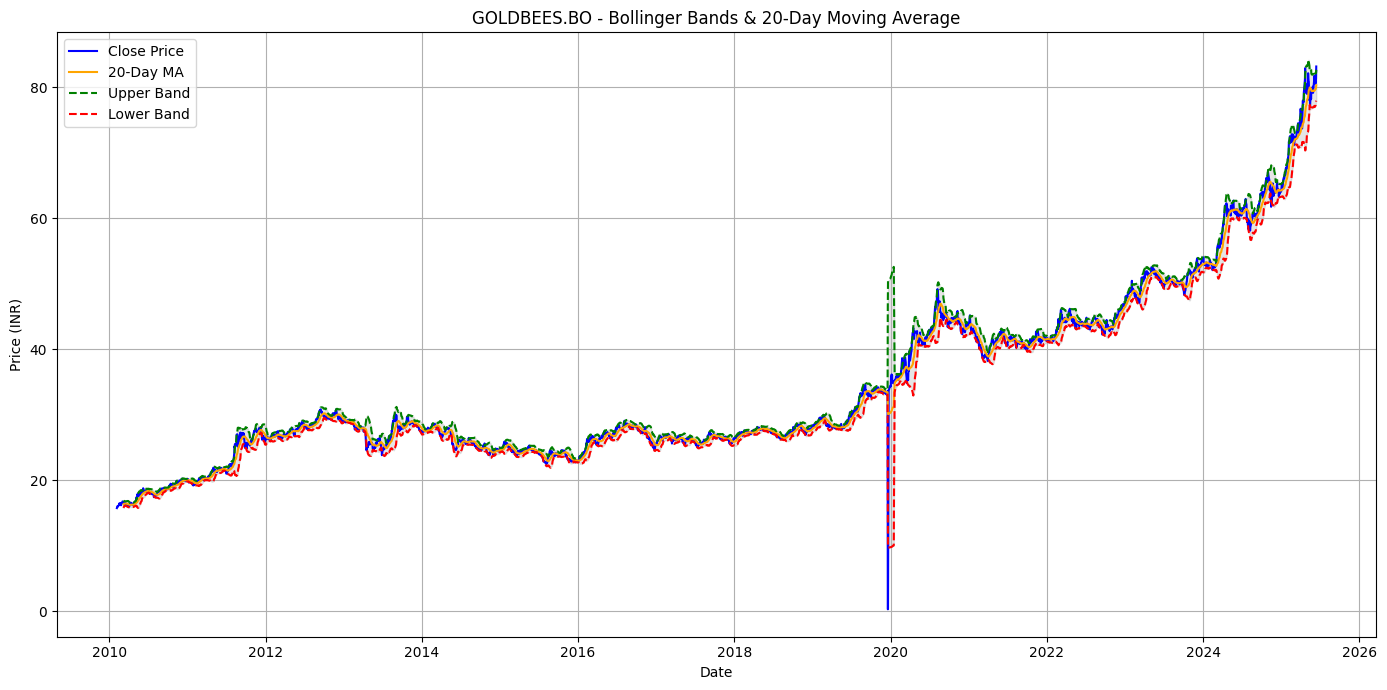

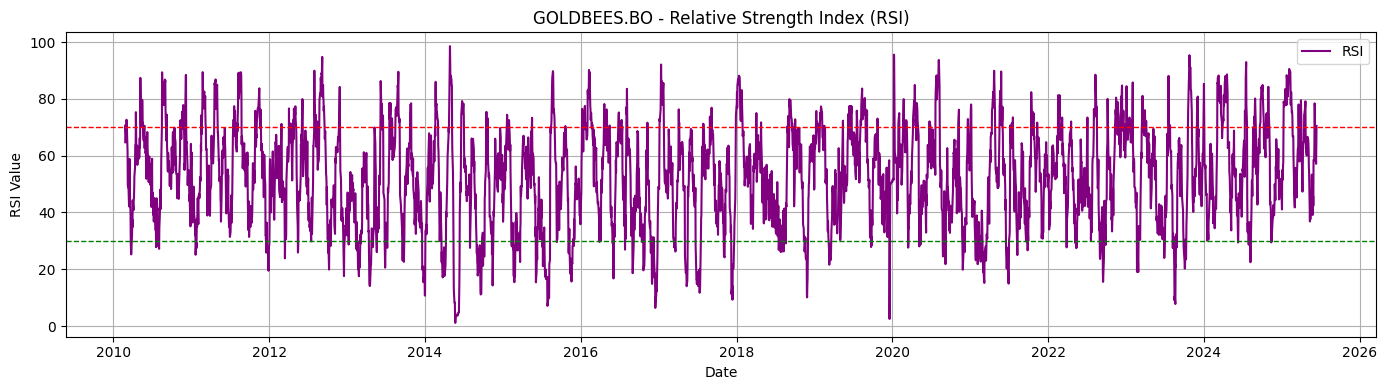

In [61]:
plot_technical_indicators(gold)

In [62]:
# ---------------------------------------------------------------------
#  BLOCK: SUPPORT / RESISTANCE DETECTION + PLOT
# ---------------------------------------------------------------------
#  ▸ Dependencies:  pip install scipy
#  ▸ Assumes `df` exists with DateTime index and 'Close' column
# ---------------------------------------------------------------------
from scipy.signal import argrelextrema

def find_levels(series, order=10):
    """
    Identify support (local minima) and resistance (local maxima) levels.

    Args:
        series (pd.Series): Price series (e.g., Close)
        order (int): Number of neighboring points to compare for extrema

    Returns:
        supports, resistances: Series of support and resistance values
    """
    idx_min = argrelextrema(series.values, np.less_equal,  order=order)[0]
    idx_max = argrelextrema(series.values, np.greater_equal, order=order)[0]
    return series.iloc[idx_min], series.iloc[idx_max]

def plot_support_resistance(df: pd.DataFrame, order: int = 10):
    """
    Plot Close price with support and resistance levels.

    Args:
        df (pd.DataFrame): DataFrame with 'Close' price and DateTime index
        order (int): Look-back window for extrema detection
    """
    price_clean = df['Close'].dropna()
    supports, resistances = find_levels(price_clean, order=order)

    plt.figure(figsize=(14, 7))
    plt.plot(price_clean, label="Close", color="blue")

    # Horizontal lines
    for lvl in supports:
        plt.axhline(lvl, color="green", linestyle="--", alpha=0.3)
    for lvl in resistances:
        plt.axhline(lvl, color="red", linestyle="--", alpha=0.3)

    # Markers
    plt.scatter(supports.index, supports.values, color="green", marker="v", s=50, label="Support")
    plt.scatter(resistances.index, resistances.values, color="red", marker="^", s=50, label="Resistance")

    plt.title("GOLDBEES.BO – Supports & Resistances (±10-day window)")
    plt.xlabel("Date")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

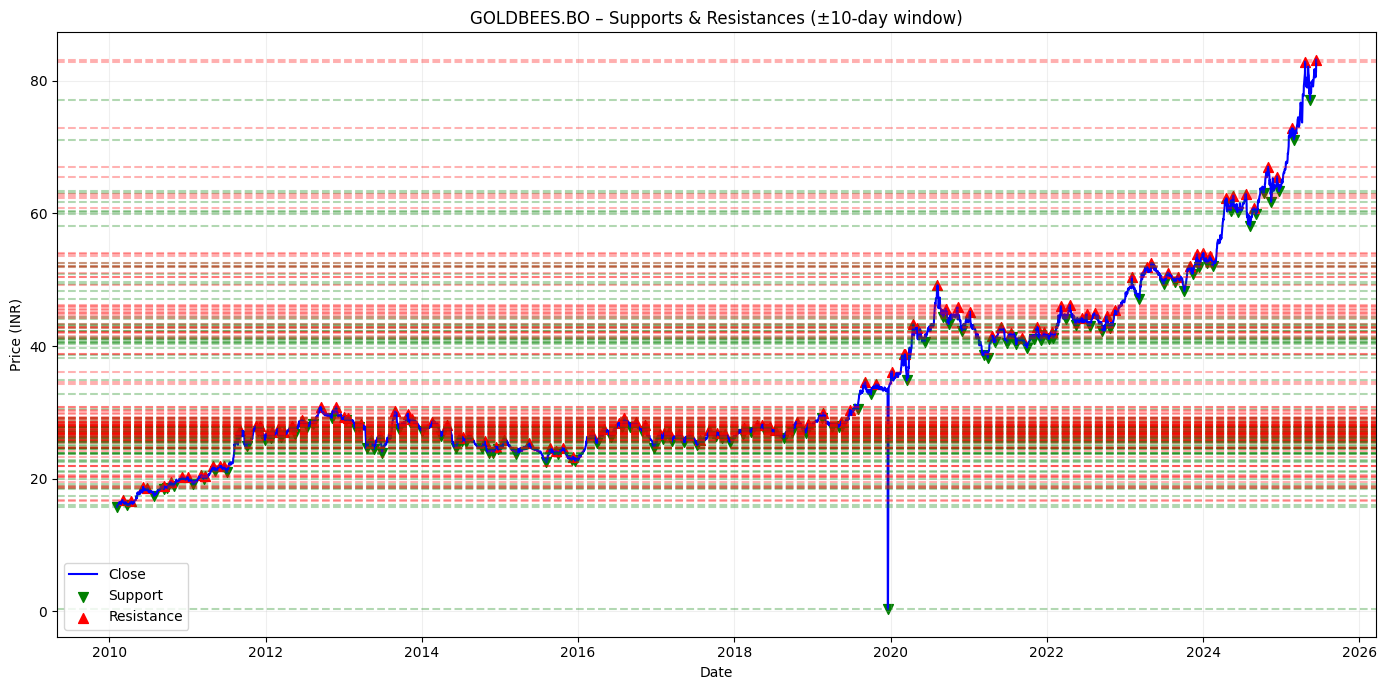

In [63]:
plot_support_resistance(gold, order=10)

In [64]:
#Add Continuous Dummy Sentiment to Gold Dataset
# ---------------------------------------------------------------------
import random

def add_dummy_sentiment(df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    Add a dummy sentiment column with float values between -1 and 1.

    Args:
        df (pd.DataFrame): DataFrame with DateTime index
        seed (int): Random seed for reproducibility

    Returns:
        pd.DataFrame: DataFrame with new 'Sentiment' column
    """
    random.seed(seed)
    df = df.copy()
    df['Sentiment'] = [round(random.uniform(-1, 1), 2) for _ in range(len(df))]  # Rounded to 2 decimal places

    # Save to file
    os.makedirs("Data", exist_ok=True)
    df.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")
    print("Continuous sentiment column added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")

    return df

In [65]:
#gold = add_dummy_sentiment(gold)

In [66]:
#Add continuous sentiment Based on Price Trend without labels
# ---------------------------------------------------------------------
def generate_sentiment_from_trend_wo_labels(df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    Generate sentiment values based on daily price trend (returns).
    Adds a 'Sentiment' column with values between -1 and 1.
    Price Movement	Sentiment Score Example
        Strong Upward (> +1%)	Between +0.5 to +1.0
        Mild Upward (0% to +1%)	Between +0.1 to +0.5
        Neutral (≈ 0%)	Around 0.0
        Mild Down (-1% to 0%)	Between -0.1 to -0.5
        Strong Down (< -1%)	Between -0.5 to -1.0

    Args:
        df (pd.DataFrame): DataFrame with 'Close' column
        seed (int): Random seed for reproducibility

    Returns:
        pd.DataFrame: DataFrame with sentiment column added
    """
    import random
    random.seed(seed)
    
    df = df.copy()
    df['Returns'] = df['Close'].pct_change()

    sentiment_scores = []
    for ret in df['Returns']:
        if pd.isna(ret):
            sentiment = 0.0
        elif ret > 0.01:
            sentiment = round(random.uniform(0.5, 1.0), 2)
        elif ret > 0.0:
            sentiment = round(random.uniform(0.1, 0.5), 2)
        elif ret > -0.01:
            sentiment = round(random.uniform(-0.5, -0.1), 2)
        else:
            sentiment = round(random.uniform(-1.0, -0.5), 2)
        sentiment_scores.append(sentiment)

    df['Sentiment'] = sentiment_scores

    # Save the final DataFrame with sentiment
    os.makedirs("Data", exist_ok=True)
    df.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")
    print("Sentiment based on price trend saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")

    return df

In [67]:
#gold = generate_sentiment_from_trend_wo_labels(gold)

In [68]:
#Add continuous sentiment Based on Price Trend with Labels
# ---------------------------------------------------------------------
def generate_sentiment_from_trend_with_labels(df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    Generate numeric sentiment scores and sentiment labels based on price returns.

    Args:
        df (pd.DataFrame): DataFrame with 'Close' column
        seed (int): Random seed for reproducibility

    Returns:
        pd.DataFrame: Updated DataFrame with 'Sentiment' and 'Sentiment_Label' columns
    """
    import random
    random.seed(seed)

    df = df.copy()
    df['Returns'] = df['Close'].pct_change()

    sentiment_scores = []
    sentiment_labels = []

    for ret in df['Returns']:
        if pd.isna(ret):
            sentiment = 0.0
        elif ret > 0.01:
            sentiment = round(random.uniform(0.5, 1.0), 2)
        elif ret > 0.0:
            sentiment = round(random.uniform(0.1, 0.5), 2)
        elif ret > -0.01:
            sentiment = round(random.uniform(-0.5, -0.1), 2)
        else:
            sentiment = round(random.uniform(-1.0, -0.5), 2)

        # Assign label
        if sentiment > 0.1:
            label = 'positive'
        elif sentiment < -0.1:
            label = 'negative'
        else:
            label = 'neutral'

        sentiment_scores.append(sentiment)
        sentiment_labels.append(label)

    df['Sentiment'] = sentiment_scores
    df['Sentiment_Label'] = sentiment_labels

    # Save to CSV
    os.makedirs("Data", exist_ok=True)
    df.to_csv("Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")
    print("Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv")

    return df

In [69]:
gold = generate_sentiment_from_trend_with_labels(gold)

Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv


In [70]:
#Visualize Sentiment vs. Price Movement
# ---------------------------------------------------------------------
def plot_sentiment_vs_price(df: pd.DataFrame):
    """
    Plot Close price and overlay sentiment values (colored by sentiment label).

    Args:
        df (pd.DataFrame): DataFrame with 'Close', 'Sentiment', and 'Sentiment_Label'
    """
    import matplotlib.pyplot as plt

    # Plot close price with sentiment overlay
    plt.figure(figsize=(14, 6))

    # Line plot for close price
    plt.plot(df.index, df['Close'], label='Close Price', color='gray', linewidth=2)

    # Scatter plot with sentiment color
    colors = df['Sentiment_Label'].map({
        'positive': 'green',
        'neutral': 'orange',
        'negative': 'red'
    })

    plt.scatter(df.index, df['Close'], c=colors, label='Sentiment', s=30, alpha=0.7)

    plt.title('GOLDBEES.BO – Price Movement with Sentiment Overlay')
    plt.xlabel('Date')
    plt.ylabel('Price (INR)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

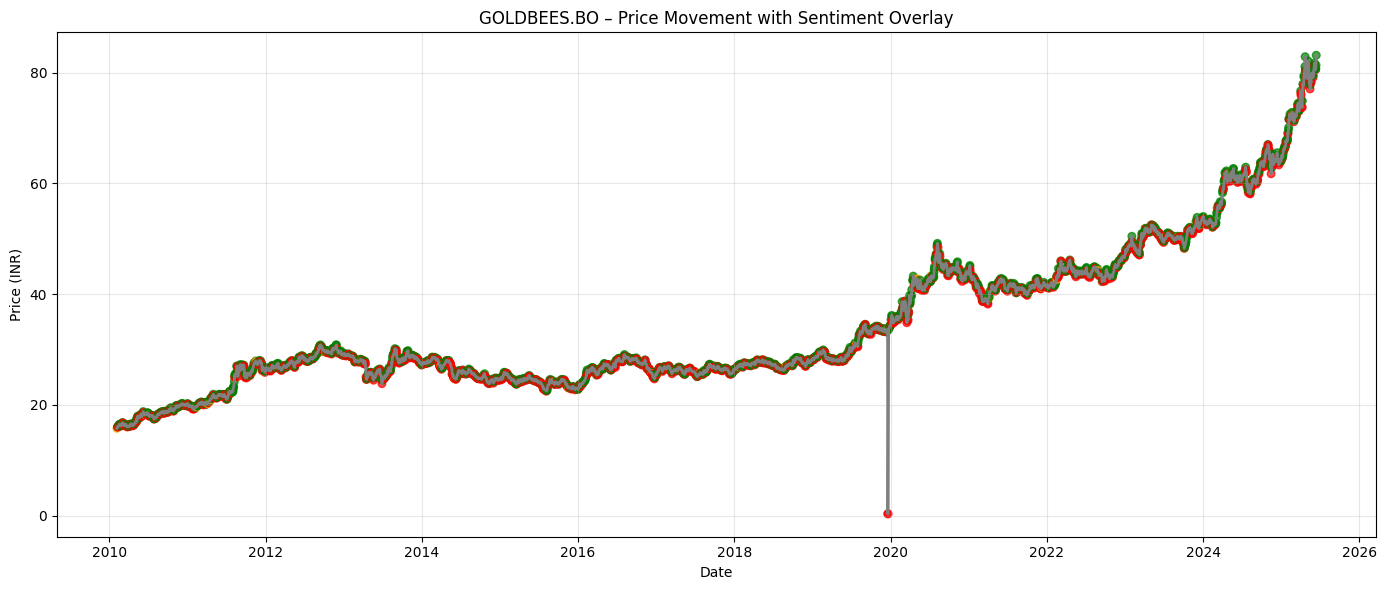

In [71]:
plot_sentiment_vs_price(gold)

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def predict_next_day_gold_price_arimax(df: pd.DataFrame, arima_order=(1, 1, 1)) -> float:
    """
    Predict next day's gold price using ARIMAX with all technical indicators as exogenous inputs.
    Ensures business-day frequency and fills missing values.

    Args:
        df (pd.DataFrame): DataFrame containing 'Close' and technical indicators
        arima_order (tuple): ARIMA model order (p, d, q)

    Returns:
        float: Predicted next-day closing price
    """
    # Required exogenous features
    exog_cols = ['Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility','RSI', 'BB_upper', 'BB_lower', 'BB_width','BB_position', 'Sentiment']
    #exog_cols = ['Returns', 'Volatility', 'RSI', 'Sentiment']  # Start with 3

    # Check if all required columns exist
    for col in exog_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Filter and clean the dataset
    df = df[['Close'] + exog_cols].copy()
    df = df.dropna()

    # Ensure business-day frequency and fill gaps
    df = df.asfreq('B')
    df = df.ffill()

    # Define target and exogenous features
    y = df['Close']
    exog = df[exog_cols]

    # Fit ARIMAX model
    print("⏳ Training ARIMAX model with all technical indicators...")
    model = SARIMAX(endog=y, exog=exog, order=arima_order, enforce_stationarity=False, enforce_invertibility=False)
    #model_fit = model.fit(disp=False)
    model_fit = model.fit(disp=False, method='powell')

    # Forecast next day's price
    next_exog = exog.iloc[[-1]].values  # last known exogenous input
    forecast = model_fit.forecast(steps=1, exog=next_exog)
    predicted_price = forecast.iloc[0]
    next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

    print(f"📆 Next Business Day: {next_day.date()}")
    print(f"📈 Predicted Price: ₹{predicted_price:.2f}")

    return next_day, predicted_price, model_fit


In [73]:
next_day, predicted_price, model_fit = predict_next_day_gold_price_arimax(gold)

⏳ Training ARIMAX model with all technical indicators...
📆 Next Business Day: 2025-06-16
📈 Predicted Price: ₹82.90


In [74]:
def plot_forecast_vs_actual(actual_df: pd.DataFrame, forecast_df: pd.DataFrame):
    """
    Plot actual vs forecasted gold prices.
    Works for both multi-step (rolling) forecasts and single next-day prediction.

    Args:
        actual_df (pd.DataFrame): DataFrame with 'Close' prices and datetime index
        forecast_df (pd.DataFrame): DataFrame with 'Forecast' values and datetime index (single or multiple rows)
    """
    import matplotlib.pyplot as plt

    # Ensure correct columns
    if 'Close' not in actual_df.columns or 'Forecast' not in forecast_df.columns:
        raise ValueError("Missing 'Close' or 'Forecast' columns.")

    # Determine cutoff for vertical line
    cutoff = actual_df.index[-1]

    plt.figure(figsize=(14, 6))

    # Plot historical prices
    plt.plot(actual_df['Close'], label='Actual Close Price', color='blue', linewidth=2)

    # Plot forecast
    plt.plot(forecast_df['Forecast'], label='Forecasted Price', color='orange', linestyle='--', marker='o')

    # Mark forecast transition point
    plt.axvline(cutoff, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    plt.text(cutoff, plt.ylim()[1]*0.98, 'Forecast Starts →', rotation=90, verticalalignment='top', color='gray')

    # Title and axes
    plt.title("GOLDBEES.BO – Actual vs Forecasted Close Price")
    plt.xlabel("Date")
    plt.ylabel("Price (INR)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

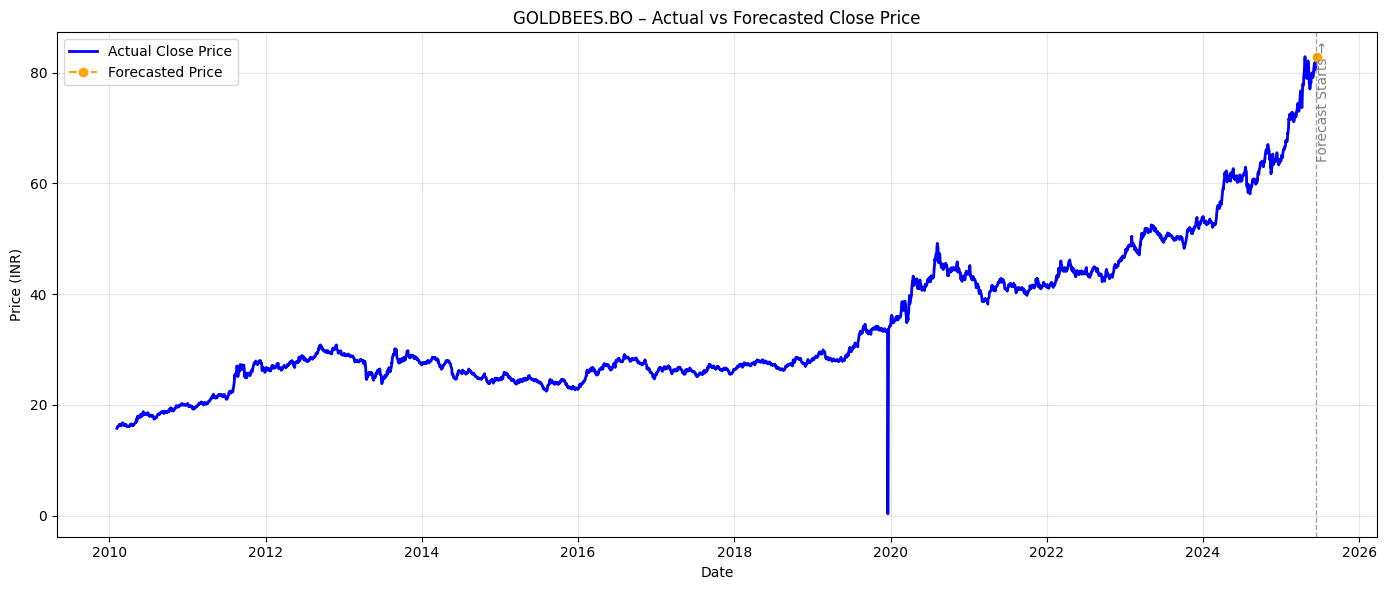

In [75]:
forecast_df = pd.DataFrame({'Forecast': [predicted_price]}, index=[next_day])
plot_forecast_vs_actual(gold, forecast_df)

In [76]:
def plot_arimax_feature_weights(model_fit, feature_names):
    """
    Plot the ARIMAX model's learned exogenous feature coefficients.

    Args:
        model_fit: Fitted SARIMAX model object
        feature_names (list): List of exogenous feature names
    """
    import matplotlib.pyplot as plt

    # Extract only the exogenous coefficients (ignore AR/MA terms)
    params = model_fit.params
    exog_params = params[params.index.isin(feature_names)]

    plt.figure(figsize=(12, 6))
    exog_params.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title("ARIMAX Exogenous Feature Coefficients")
    plt.xlabel("Features")
    plt.ylabel("Coefficient Value")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

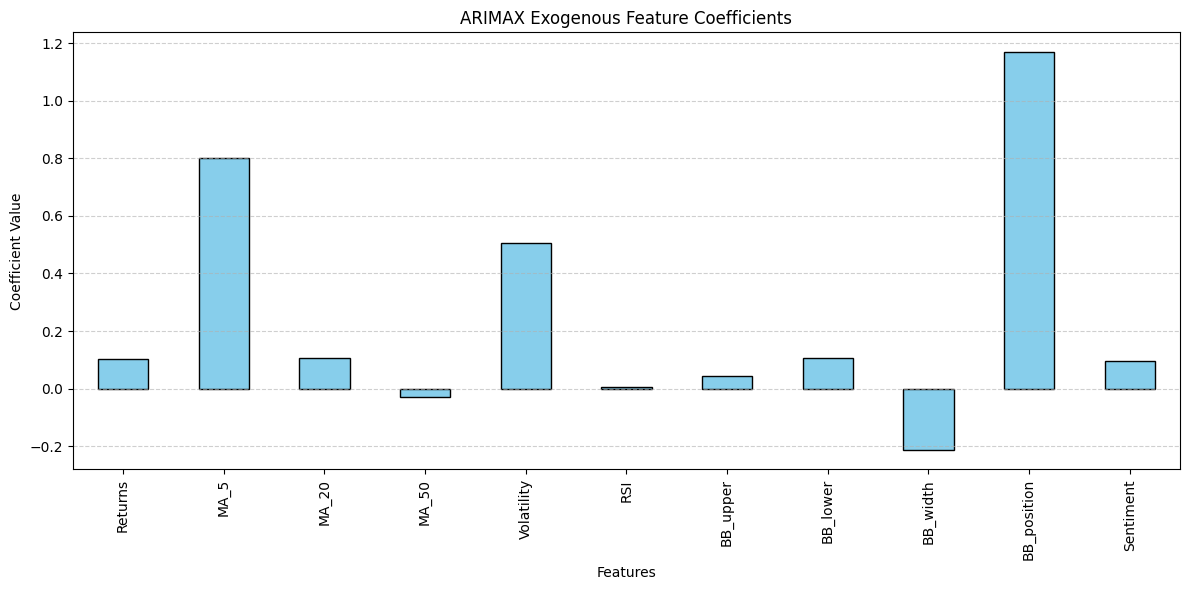

In [77]:
plot_arimax_feature_weights(model_fit, [
    'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
    'RSI', 'BB_upper', 'BB_lower', 'BB_width',
    'BB_position', 'Sentiment'
])

In [78]:
#Plot ARIMAX model's exogenous feature weights as a horizontal, sorted bar chart.
# ---------------------------------------------------------------------
def plot_arimax_feature_weights_h(model_fit, feature_names):
    """
    Plot ARIMAX model's exogenous feature weights as a horizontal, sorted bar chart.

    Args:
        model_fit: Fitted SARIMAX model object
        feature_names (list): Names of exogenous features in order of model input
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Extract and filter coefficients
    params = model_fit.params
    exog_params = params[params.index.isin(feature_names)]

    # Convert to DataFrame for easy sorting and plotting
    coef_df = pd.DataFrame({
        'Feature': exog_params.index,
        'Weight': exog_params.values
    }).sort_values(by='Weight', ascending=True)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(coef_df['Feature'], coef_df['Weight'], color='deepskyblue', edgecolor='black')
    plt.title('ARIMAX Feature Weights (Exogenous Variables)', fontsize=14)
    plt.xlabel('Coefficient Weight')
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


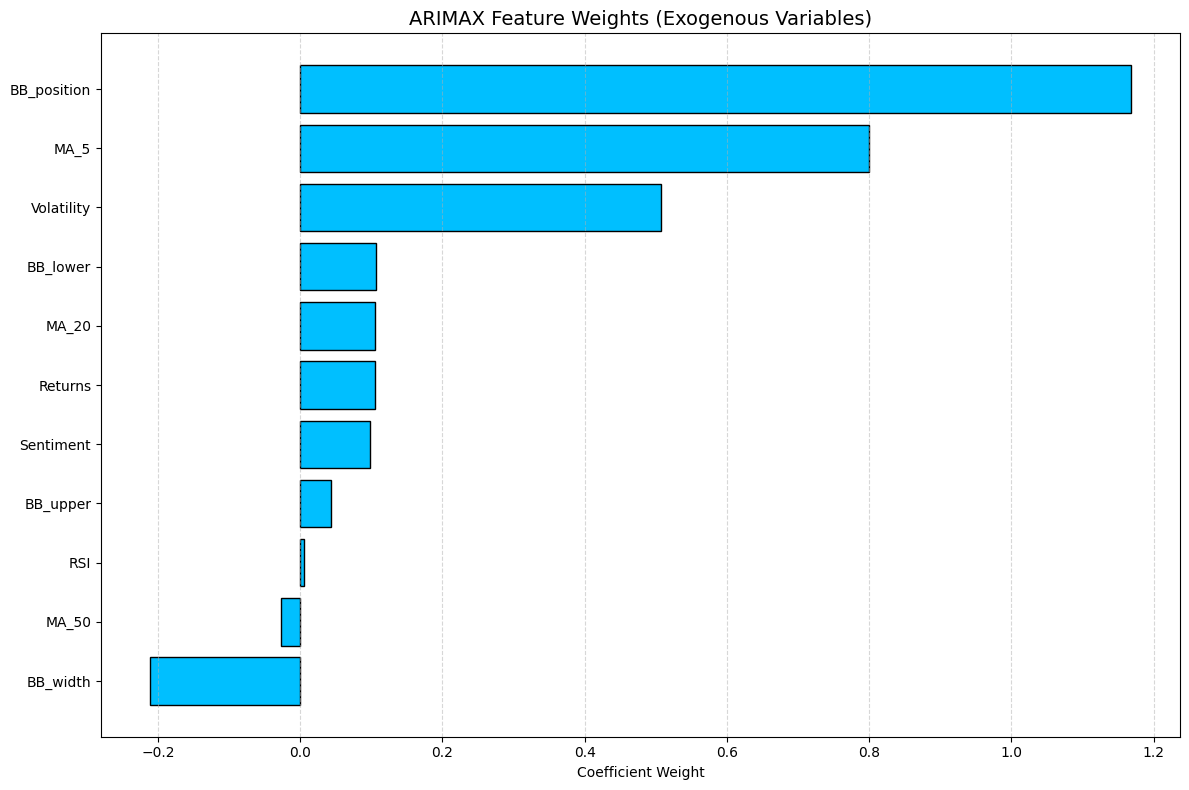

In [79]:
plot_arimax_feature_weights_h(model_fit, [
    'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
    'RSI', 'BB_upper', 'BB_lower', 'BB_width',
    'BB_position', 'Sentiment'
])

In [80]:
#Perform rolling ARIMAX forecast for multiple future days
# ---------------------------------------------------------------------   
def rolling_arimax_forecast(df: pd.DataFrame, days_ahead: int = 5, arima_order=(1, 1, 1)) -> pd.DataFrame:
    """
    Perform rolling ARIMAX forecast for multiple future days using the existing add_technical_indicators() function.

    Args:
        df (pd.DataFrame): DataFrame with 'Close' and initial indicators
        days_ahead (int): Number of future business days to predict
        arima_order (tuple): ARIMA model order (p, d, q)

    Returns:
        pd.DataFrame: Forecasted prices with business day index
    """
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import pandas as pd
    import numpy as np

    # Required features
    exog_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]


    # Filter and clean the dataset
    df = df[['Close'] + exog_cols].copy()
    df = df.dropna()

    # Ensure business-day frequency and fill gaps
    df = df.asfreq('B')
    df = df.ffill()

    # Initialize predictions and working data
    forecasts = []
    current_data = df.copy()
    final_model_fit = None

    for step in range(days_ahead):
        current_data.index.freq = 'B'  # Explicitly set business-day frequency
        y = current_data['Close']
        exog = current_data[exog_cols]

        # Fit ARIMAX model
        model = SARIMAX(endog=y, exog=exog, order=arima_order, enforce_stationarity=False, enforce_invertibility=False)
        #model_fit = model.fit(disp=False)
        model_fit = model.fit(disp=False, method='powell')
        final_model_fit = model_fit  # save the last model for plotting

        # Forecast next day
        last_exog = exog.iloc[[-1]].values  # shape (1, n)
        next_price = model_fit.forecast(steps=1, exog=last_exog).iloc[0]
        next_day = y.index[-1] + pd.tseries.offsets.BDay(1)

        # Simulate new row using last known data
        next_row = current_data.iloc[[-1]].copy()
        next_row.index = [next_day]
        next_row['Close'] = next_price
        next_row['Sentiment'] = current_data['Sentiment'].iloc[-1]  # Keep last known sentiment

        # Append to working dataset
        extended = pd.concat([current_data, next_row])
        extended = add_technical_indicators(extended)

        # Keep only the last row (the newly generated one)
        next_row_updated = extended.loc[[next_day]]

        # Store forecast
        forecasts.append((next_day, next_price))

        # Update current data
        current_data = pd.concat([current_data, next_row_updated])

    # Return as DataFrame
    forecast_df = pd.DataFrame(forecasts, columns=['Date', 'Forecast'])
    forecast_df.set_index('Date', inplace=True)
    print("📊 Rolling ARIMAX forecast with technical indicators completed.")
    return forecast_df, final_model_fit


In [81]:
forecast_df, final_model_fit = rolling_arimax_forecast(gold, days_ahead=5)
print(forecast_df)


Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3953 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3954 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3955 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3956 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3957 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv
📊 Rolling ARIMAX for

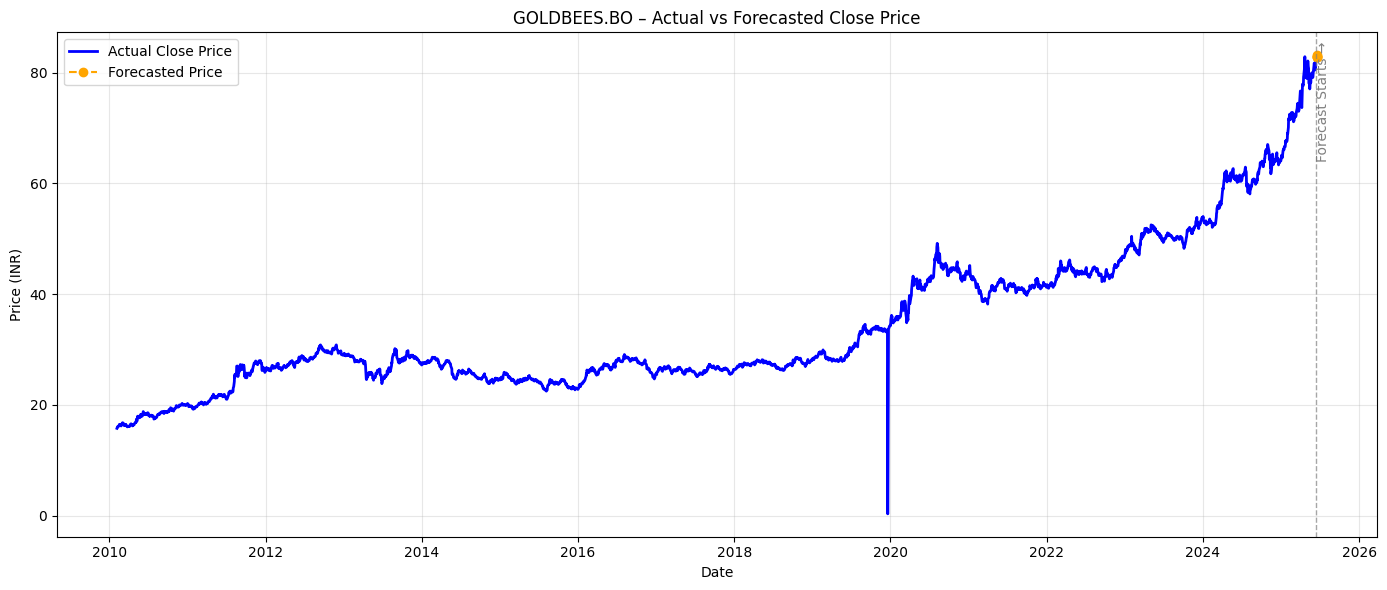

In [82]:
plot_forecast_vs_actual(gold, forecast_df)

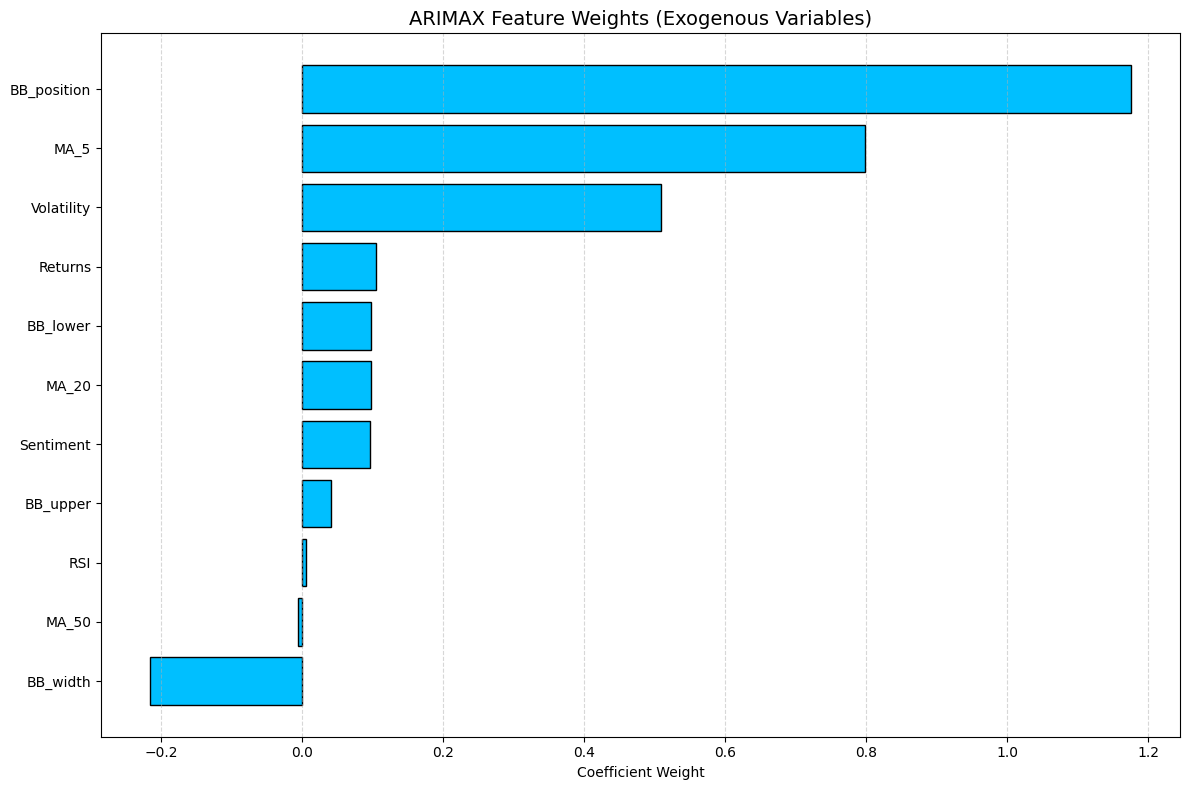

In [83]:
plot_arimax_feature_weights_h(final_model_fit, [
    'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
    'RSI', 'BB_upper', 'BB_lower', 'BB_width',
    'BB_position', 'Sentiment'
])

In [84]:
#Predict next-day gold price using XGBoost with technical indicators as features.
# ---------------------------------------------------------------------
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


def predict_next_day_gold_price_xgboost(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Predict next-day gold price using XGBoost with technical indicators as features.
    Saves train/test datasets to CSV inside Data/XGboost_Train.

    Args:
        df (pd.DataFrame): DataFrame with 'Close' and technical indicators
        test_size (float): Fraction of data to use as test split
        random_state (int): Seed for reproducibility

    Returns:
        float: Predicted price for the next day
    """
    # Feature columns (same as ARIMAX)
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    df = df[['Close'] + feature_cols].dropna()
    df = df.asfreq('B')
    df = df.ffill()

    # Shift Close to create "next day" target
    df['Target'] = df['Close'].shift(-1)
    df = df.dropna()

    # Features and target
    X = df[feature_cols]
    y = df['Target']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Create folder if it doesn't exist
    output_dir = "Data/XGboost_Train"
    os.makedirs(output_dir, exist_ok=True)

    # Save datasets to CSV
    train_df = X_train.copy()
    train_df['Target'] = y_train
    train_df.to_csv(os.path.join(output_dir, "train_data.csv"))
    print("✅ Saved training set to Data/XGboost_Train/train_data.csv")

    test_df = X_test.copy()
    test_df['Target'] = y_test
    test_df.to_csv(os.path.join(output_dir, "test_data.csv"))
    print("✅ Saved test set to Data/XGboost_Train/test_data.csv")

    # Train XGBoost model
    model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=random_state)
    model.fit(X_train, y_train)

    # Predict next day price
    latest_features = X.iloc[[-1]]
    next_day_price = model.predict(latest_features)[0]

    # Optional validation error
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"📉 XGBoost RMSE on validation set: {rmse:.2f}")
    print(f"📈 Predicted next day's gold price (XGBoost): ₹{next_day_price:.2f}")

    #return next_day_price, model
    return next_day_price, model, X_test, y_test, y_pred



In [ ]:
def plot_predictions_vs_actuals(y_test: pd.Series, y_pred: np.ndarray, model_name="Model"):
    """
    Plot predicted vs actual prices for test set.

    Args:
        y_test (pd.Series): Actual prices with datetime index
        y_pred (np.ndarray): Predicted prices
        model_name (str): Name of the model (for title)
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure alignment of predicted series
    pred_series = pd.Series(y_pred, index=y_test.index)

    plt.figure(figsize=(14, 6))
    plt.plot(y_test.index, y_test, label='Actual Price', color='blue', linewidth=2)
    plt.plot(pred_series.index, pred_series, label='Predicted Price', color='orange', linestyle='--', marker='o')

    plt.title(f"{model_name} – Actual vs Predicted Gold Prices (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

✅ Saved training set to Data/XGboost_Train/train_data.csv
✅ Saved test set to Data/XGboost_Train/test_data.csv
📉 XGBoost RMSE on validation set: 14.21
📈 Predicted next day's gold price (XGBoost): ₹45.93


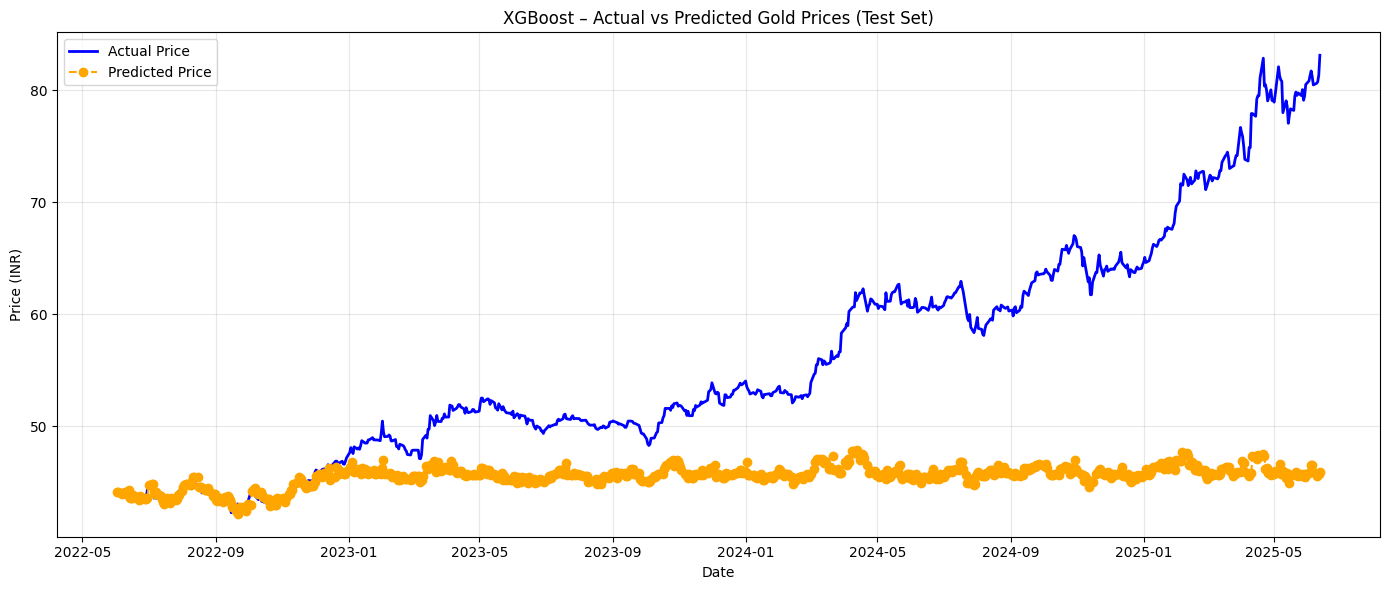

In [116]:
next_price, xgb_model, X_test, y_test, y_pred = predict_next_day_gold_price_xgboost(gold)
plot_predictions_vs_actuals(y_test, y_pred, model_name="XGBoost")

In [103]:
#Plot Feature Importance
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_xgboost_feature_importance(model, feature_names):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='deepskyblue')
    plt.title("XGBoost Feature Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.show()

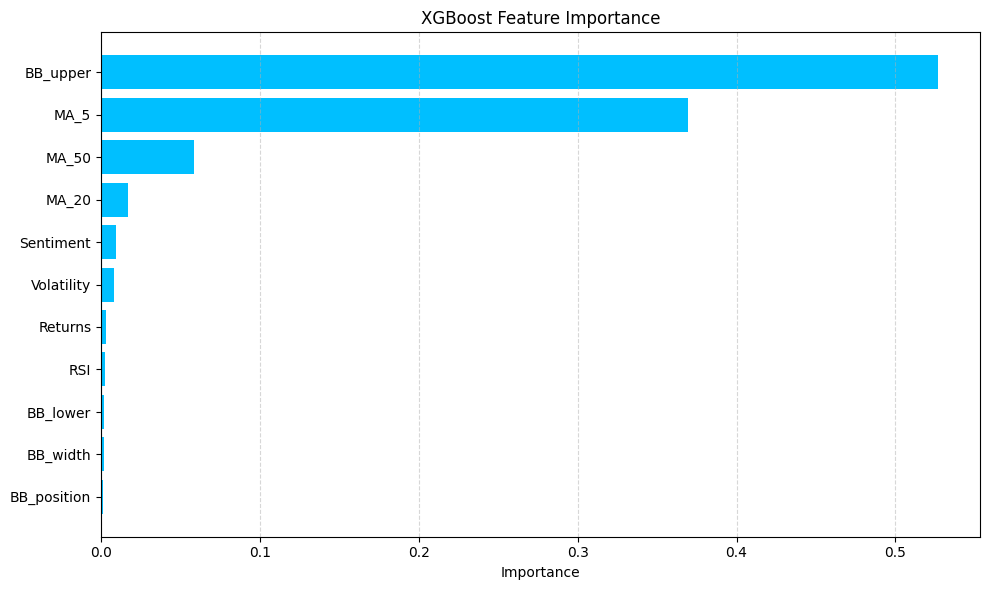

In [87]:
plot_xgboost_feature_importance(xgb_model, [
    'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
    'RSI', 'BB_upper', 'BB_lower', 'BB_width',
    'BB_position', 'Sentiment'
])

In [94]:
#Predict the next day's gold price using Random Forest
# ---------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def predict_next_day_gold_price_rf(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Predict the next day's gold price using Random Forest and save train/test CSVs.

    Args:
        df (pd.DataFrame): DataFrame with 'Close' and technical indicators
        test_size (float): Fraction of data used for test set
        random_state (int): Seed for reproducibility

    Returns:
        tuple: (predicted_price, model, X_test, y_test, y_pred)
    """
    # Features
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    # Clean input
    df = df[['Close'] + feature_cols].dropna()
    df = df.asfreq('B')
    df = df.ffill()
    df['Target'] = df['Close'].shift(-1)
    df = df.dropna()

    X = df[feature_cols]
    y = df['Target']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Save train/test datasets
    save_path = "Data/RandomForest_Train"
    os.makedirs(save_path, exist_ok=True)

    train_df = X_train.copy()
    train_df['Target'] = y_train
    train_df.to_csv(os.path.join(save_path, "train_data.csv"))
    print("✅ Saved training set to Data/RandomForest_Train/train_data.csv")

    test_df = X_test.copy()
    test_df['Target'] = y_test
    test_df.to_csv(os.path.join(save_path, "test_data.csv"))
    print("✅ Saved test set to Data/RandomForest_Train/test_data.csv")

    # Train model
    model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=random_state)
    model.fit(X_train, y_train)

    # Predict
    next_day_input = X.iloc[[-1]]
    predicted_price = model.predict(next_day_input)[0]

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"📉 Random Forest RMSE on test set: {rmse:.2f}")
    print(f"📈 Predicted next day's gold price: ₹{predicted_price:.2f}")

    return predicted_price, model, X_test, y_test, y_pred


✅ Saved training set to Data/RandomForest_Train/train_data.csv
✅ Saved test set to Data/RandomForest_Train/test_data.csv
📉 Random Forest RMSE on test set: 14.51
📈 Predicted next day's gold price: ₹45.25


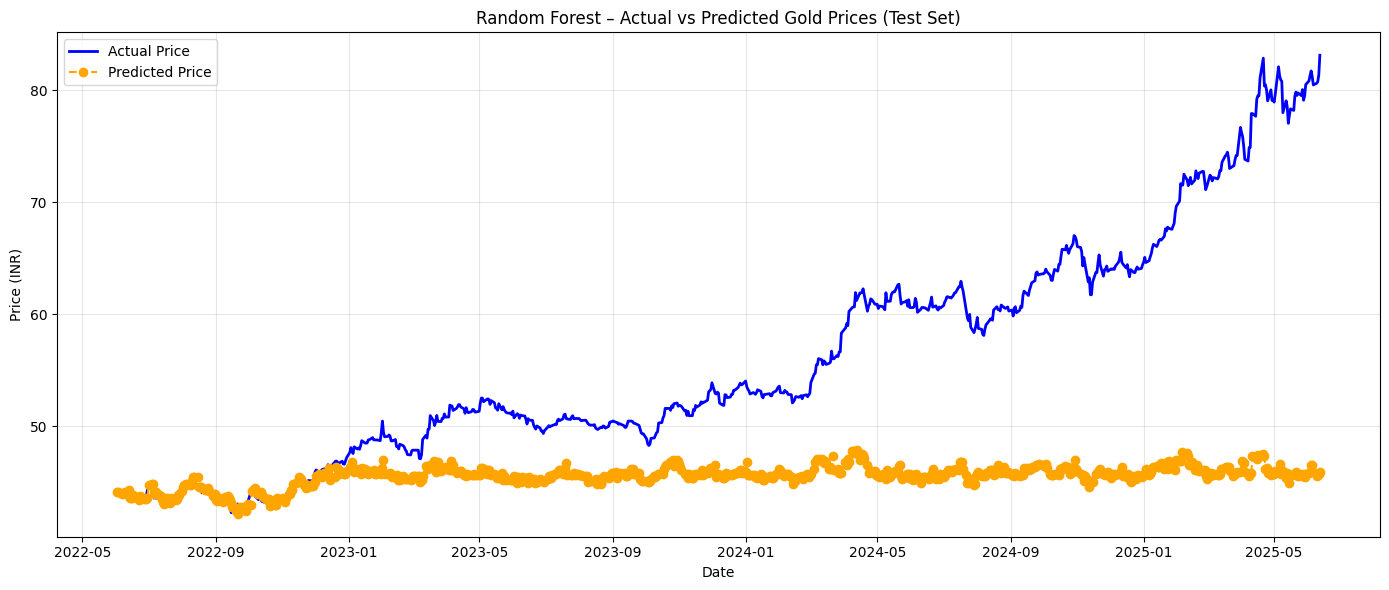

In [111]:
next_price_rf, rf_model, X_test_rf, y_test_rf, y_pred_rf = predict_next_day_gold_price_rf(gold)
plot_predictions_vs_actuals(y_test, y_pred, model_name="Random Forest")

In [112]:
#Plot feature importance for a trained Random Forest model.
# ---------------------------------------------------------------------

def plot_rf_feature_importance(model, feature_names):
    """
    Plot feature importance for a trained Random Forest model.

    Args:
        model: Trained RandomForestRegressor
        feature_names (list): List of feature names used in training
    """
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], color='deepskyblue', edgecolor='black')
    plt.title("Random Forest – Feature Importance")
    plt.xlabel("Importance")
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


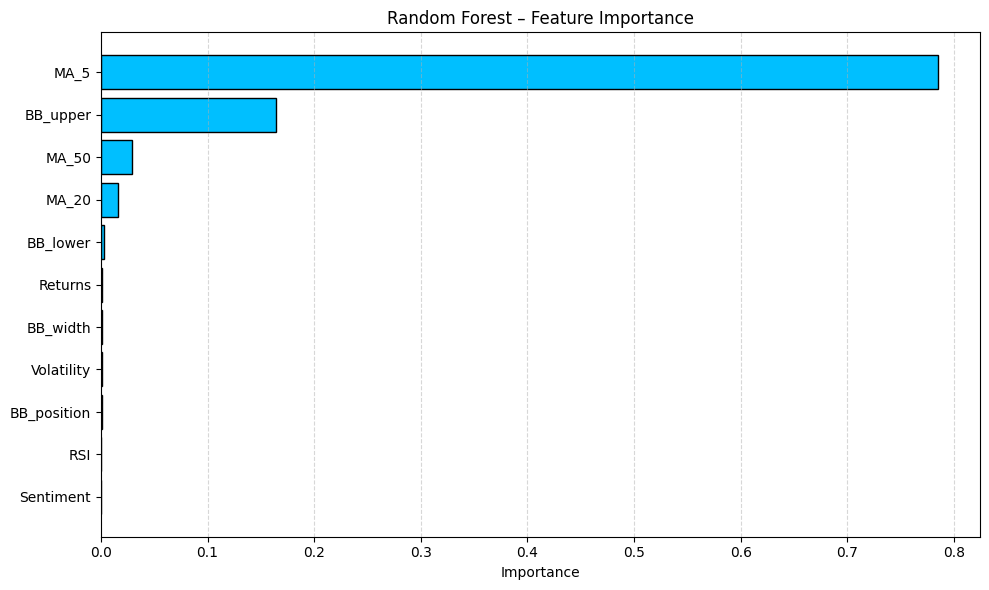

In [113]:
feature_cols = [
    'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
    'RSI', 'BB_upper', 'BB_lower', 'BB_width',
    'BB_position', 'Sentiment'
]

plot_rf_feature_importance(rf_model, feature_cols)

In [125]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os



class GoldPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])
    



def predict_next_day_gold_price_lstm(df: pd.DataFrame, sequence_length=10, epochs=50, batch_size=16, lr=0.001):
    import os
    from sklearn.preprocessing import MinMaxScaler
    import torch
    from torch.utils.data import DataLoader
    import numpy as np
    import pandas as pd

    # Ensure technical indicators are present
    feature_cols = [
        'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
        'RSI', 'BB_upper', 'BB_lower', 'BB_width',
        'BB_position', 'Sentiment'
    ]

    df = df[['Close'] + feature_cols].dropna()
    df = df.asfreq('B')
    df = df.ffill()
    df['Target'] = df['Close'].shift(-1)
    df.dropna(inplace=True)

    # Normalize
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[feature_cols])
    y_scaled = scaler.fit_transform(df[['Target']])

    # Create sequences
    X_seq, y_seq, dates = [], [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i + sequence_length])
        y_seq.append(y_scaled[i + sequence_length])
        dates.append(df.index[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    dates = np.array(dates)

    # Train/test split
    split = int(len(X_seq) * 0.9)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    date_train, date_test = dates[:split], dates[split:]

    # Save CSVs
    os.makedirs("Data/LSTM", exist_ok=True)
    pd.DataFrame(X_train.reshape(X_train.shape[0], -1)).assign(Target=y_train, Date=date_train).to_csv("Data/LSTM/train_data.csv", index=False)
    pd.DataFrame(X_test.reshape(X_test.shape[0], -1)).assign(Target=y_test, Date=date_test).to_csv("Data/LSTM/test_data.csv", index=False)

    # Select device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✅ PyTorch running on: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

    # Model definition
    model = LSTMModel(input_size=X_seq.shape[2]).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Prepare dataloader
    train_ds = GoldPriceDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Training
    print("🧠 Training started...")
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb).squeeze()
            loss = criterion(output, yb.squeeze())
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} - Loss: {loss.item():.6f}")

    # Predict next business day
    model.eval()
    last_seq = torch.tensor(X_scaled[-sequence_length:], dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        next_pred = model(last_seq).cpu().numpy()
        test_preds = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

    # Reverse scaling for next day price
    predicted_price = scaler.inverse_transform(
        np.concatenate([np.zeros((1, len(feature_cols))), next_pred], axis=1)
    )[:, -1][0]

    print(f"📈 Predicted next day's gold price (LSTM): ₹{predicted_price:.2f}")

    return predicted_price, model, y_test, test_preds, date_test




In [126]:
#  Plot actual vs predicted prices for LSTM model.
#- ---------------------------------------------------------------------
def plot_lstm_predictions_vs_actuals(y_test: np.ndarray, y_pred: np.ndarray, dates: np.ndarray = None):
    """
    Plot actual vs predicted prices for LSTM model.

    Args:
        y_test (np.ndarray): Actual scaled target prices
        y_pred (np.ndarray): Predicted scaled target prices
        dates (np.ndarray, optional): Corresponding datetime index for x-axis
    """
    import matplotlib.pyplot as plt

    # Flatten in case shapes are (N, 1)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # X-axis
    x = dates if dates is not None else np.arange(len(y_test))

    plt.figure(figsize=(14, 6))
    plt.plot(x, y_test, label="Actual Price", color="blue", linewidth=2)
    plt.plot(x, y_pred, label="Predicted Price", color="orange", linestyle="--", marker='o')
    plt.title("LSTM – Actual vs Predicted Gold Prices (Test Set)")
    plt.xlabel("Date" if dates is not None else "Index")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


✅ PyTorch running on: GPU (CUDA)
🧠 Training started...
Epoch 0 - Loss: 0.000094
Epoch 10 - Loss: 0.000040
Epoch 20 - Loss: 0.000130
Epoch 30 - Loss: 0.000043
Epoch 40 - Loss: 0.000029
Epoch 49 - Loss: 0.000076
📈 Predicted next day's gold price (LSTM): ₹76.96


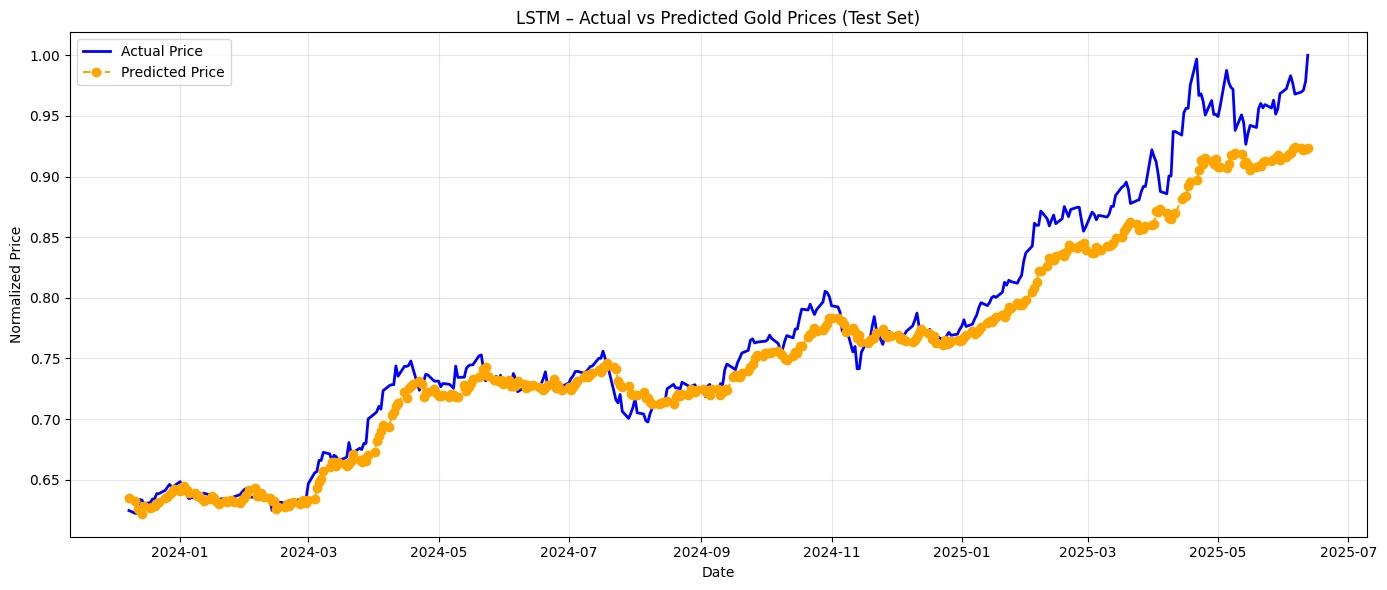

In [127]:
next_price_lstm, lstm_model, y_test, y_pred, date_test = predict_next_day_gold_price_lstm(gold)
plot_lstm_predictions_vs_actuals(y_test, y_pred, dates=date_test)
# next_price_lstm, lstm_model = predict_next_day_gold_price_lstm(gold)

In [129]:
def compare_model_predictions(actual_price: float,
                              arimax_price: float,
                              xgb_price: float,
                              rf_price: float,
                              lstm_price: float) -> None:
    """
    Compare predicted next-day prices from different models.

    Args:
        actual_price (float): Last actual known price
        arimax_price (float): ARIMAX predicted price
        xgb_price (float): XGBoost predicted price
        rf_price (float): Random Forest predicted price
        lstm_price (float): LSTM predicted price
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    data = {
        'Model': ['Actual (Today)', 'ARIMAX', 'XGBoost', 'Random Forest', 'LSTM'],
        'Price': [actual_price, arimax_price, xgb_price, rf_price, lstm_price]
    }
    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(df['Model'], df['Price'], color=['gray', 'orange', 'green', 'blue', 'purple'])

    # Annotate price on top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.2, f"₹{yval:.2f}", ha='center', va='bottom')

    plt.title("📊 Next-Day Gold Price Predictions from Different Models")
    plt.ylabel("Price (INR)")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()



Step 1: Downloading gold price data (GOLDBEES.BO)...
Download complete.
Price            Close        High         Low        Open      Volume
Ticker     GOLDBEES.BO GOLDBEES.BO GOLDBEES.BO GOLDBEES.BO GOLDBEES.BO
Date                                                                  
2010-02-05   15.765000   16.011000     15.7385   15.980000     2836000
2010-02-08   16.062500   16.098000     15.9600   16.031000      445700
2010-02-09   15.997200   16.065001     15.9600   16.065001      669100
2010-02-10   16.060900   16.108999     16.0221   16.090000      335400
2010-02-11   16.059299   16.099001     16.0305   16.099001      385300
Current working directory: d:\Python\04_Python_DA225o\zDL_Project_Gold_Price_02
Saved raw gold price data to Data/GOLDBEES_ETF_price_data.csv
                 Open       High      Low      Close   Volume
Date                                                         
2010-02-05  15.980000  16.011000  15.7385  15.765000  2836000
2010-02-08  16.031000  16.09800

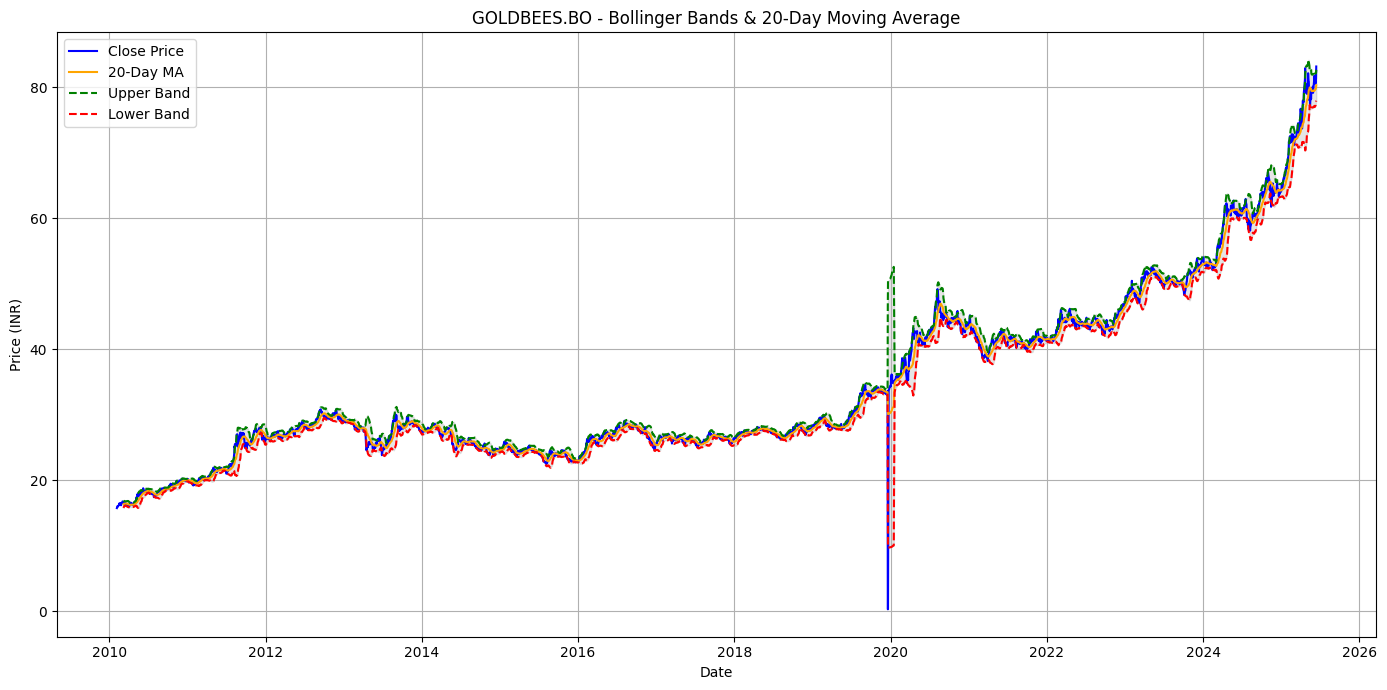

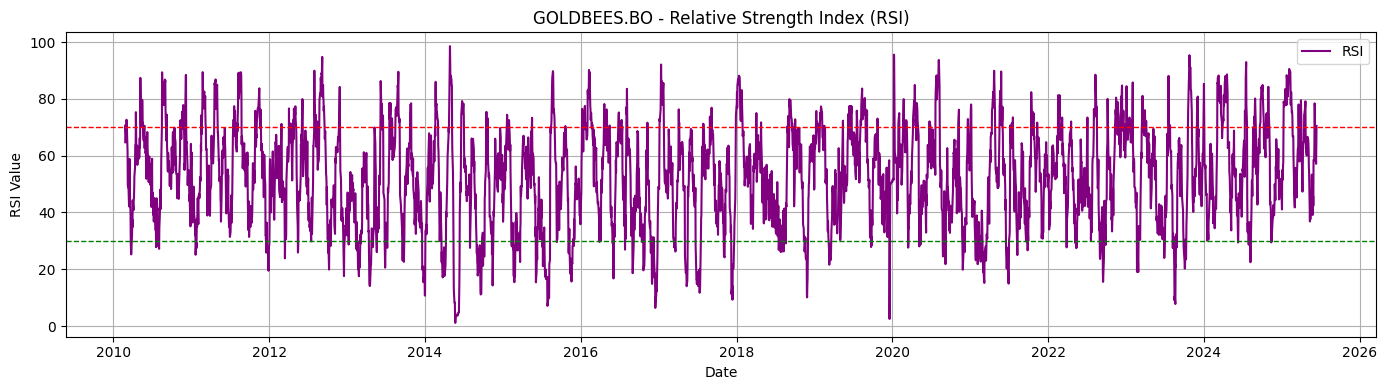

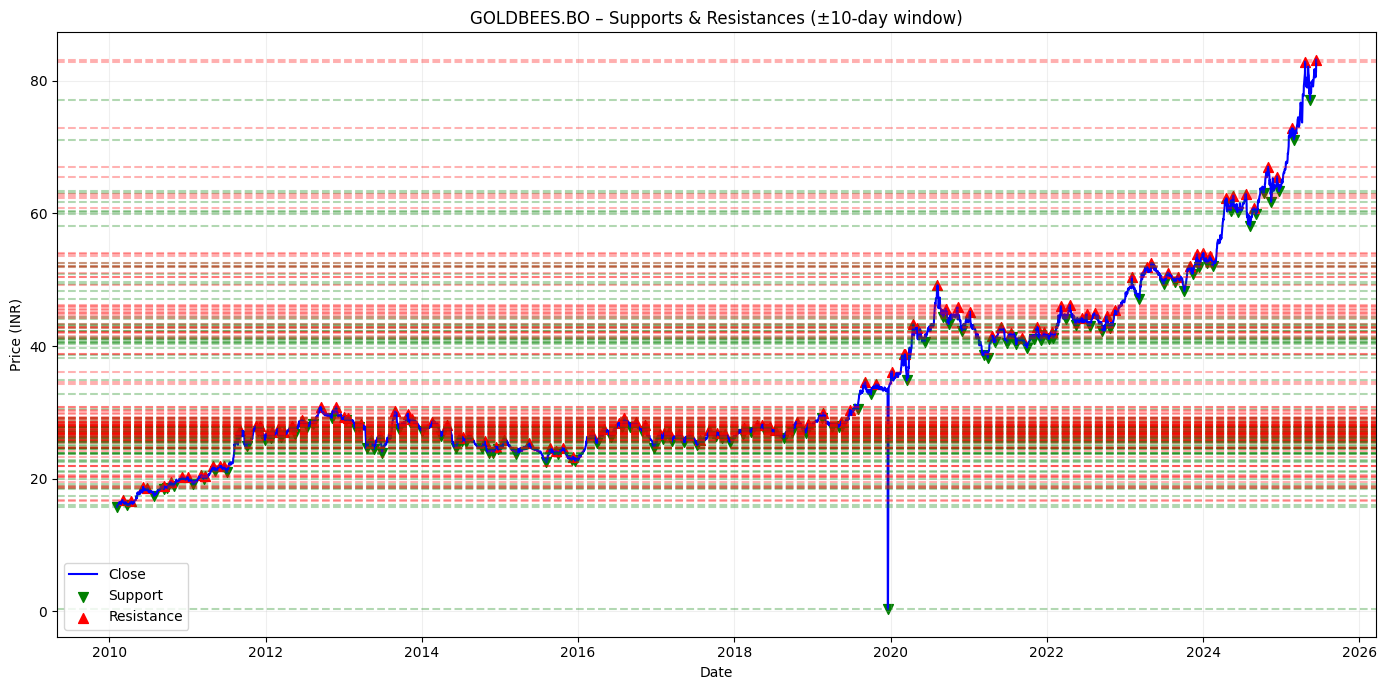

Sentiment columns added and saved to Data/GOLDBEES_ETF_price_data_technical_indicators_sentiment.csv


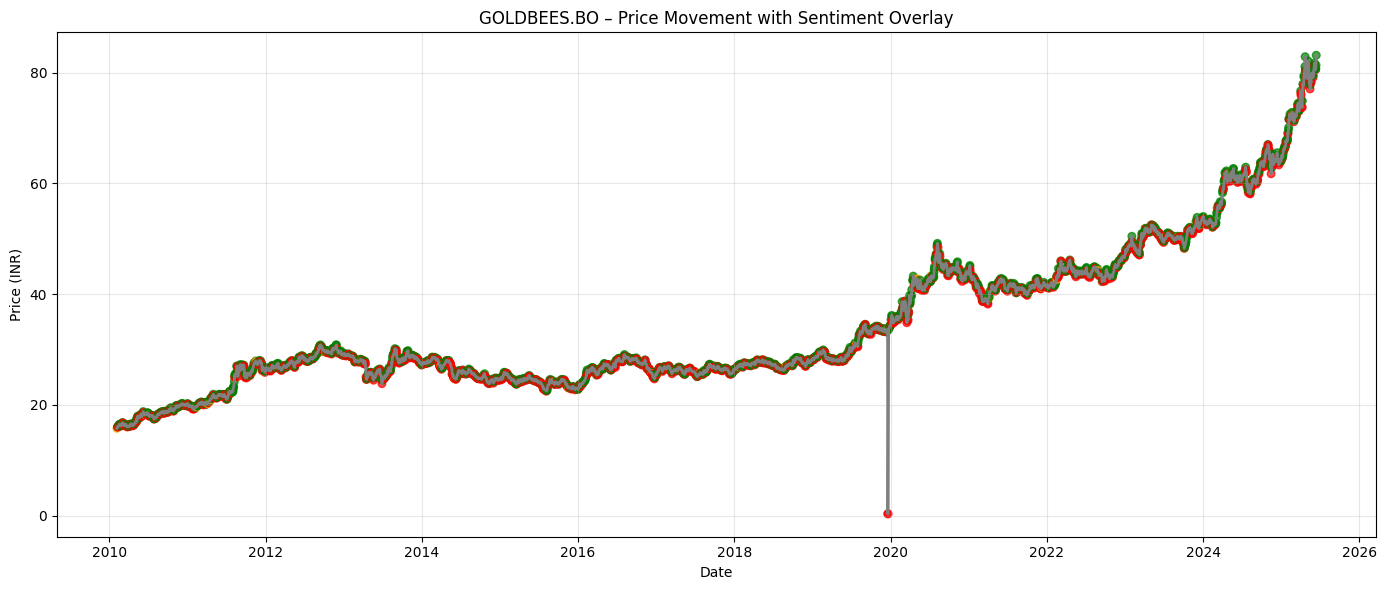

⏳ Training ARIMAX model with all technical indicators...
📆 Next Business Day: 2025-06-16
📈 Predicted Price: ₹82.90


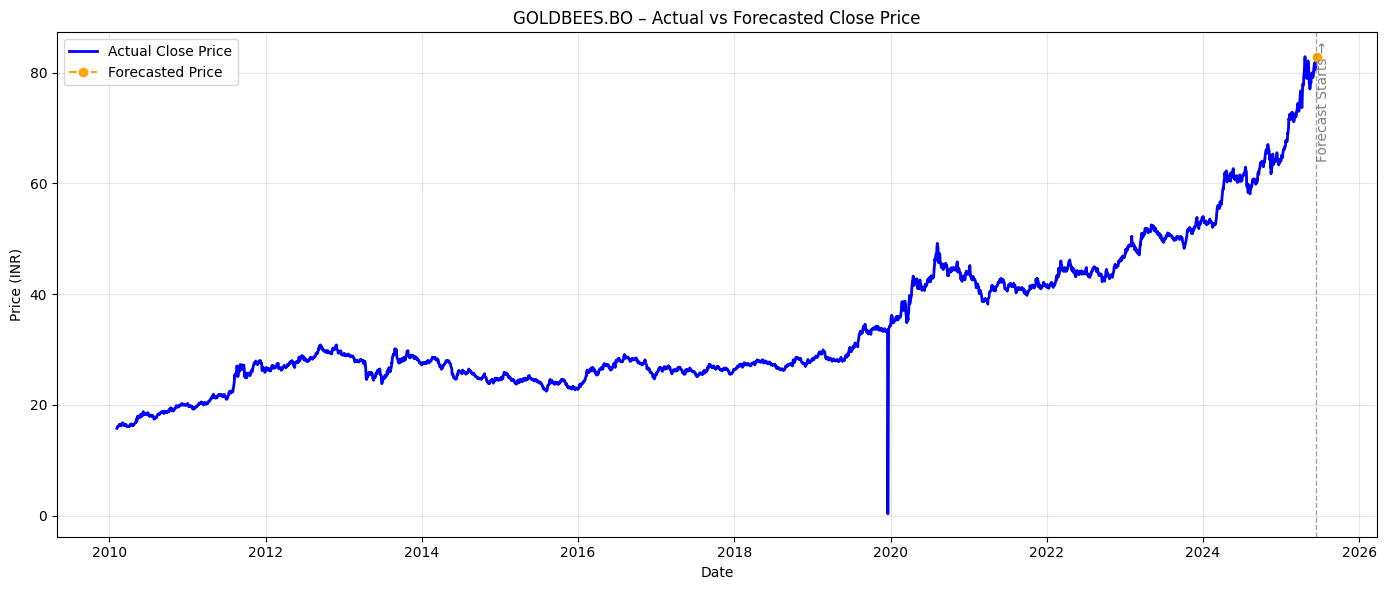

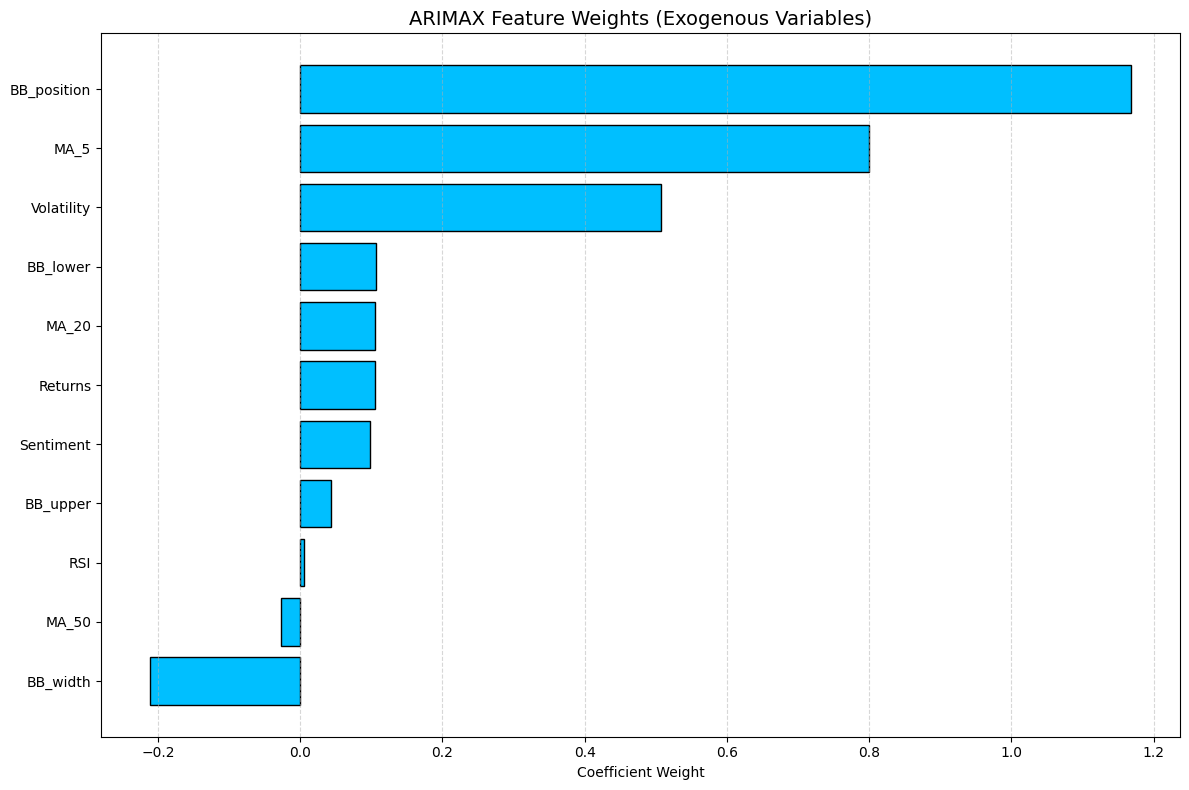


Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3953 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3954 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3955 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3956 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv

Step 2: Adding technical indicators...

Step 3: Calculating Bollinger Bands...

Added indicators to 3957 rows.
Saved technical indicators to Data/GOLDBEES_ETF_price_data_technical_indicators.csv
📊 Rolling ARIMAX for

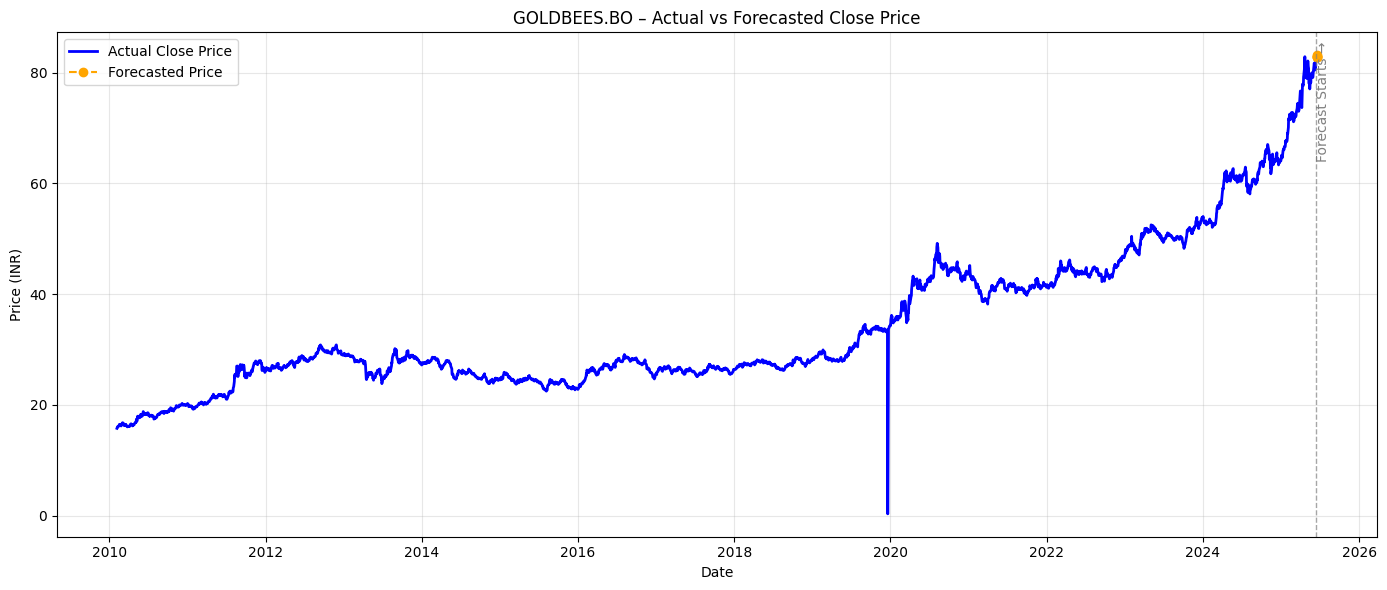

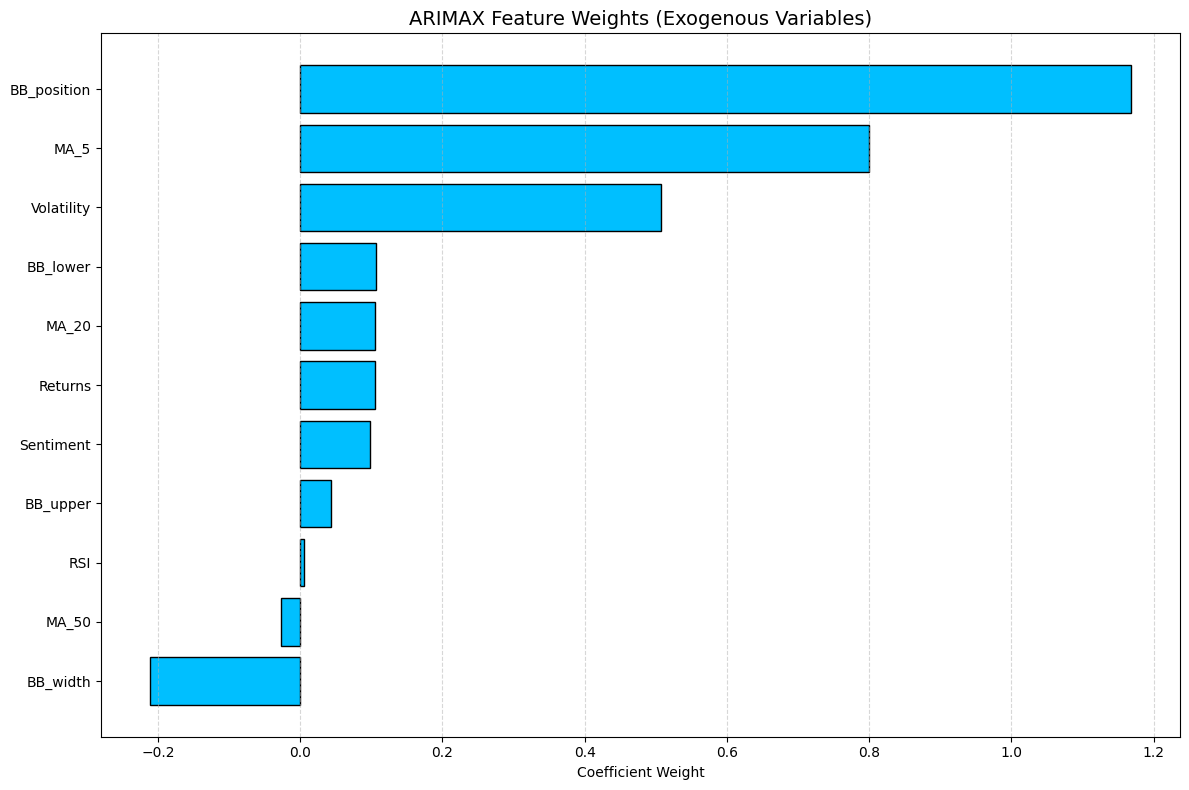

✅ Saved training set to Data/XGboost_Train/train_data.csv
✅ Saved test set to Data/XGboost_Train/test_data.csv
📉 XGBoost RMSE on validation set: 14.21
📈 Predicted next day's gold price (XGBoost): ₹45.93


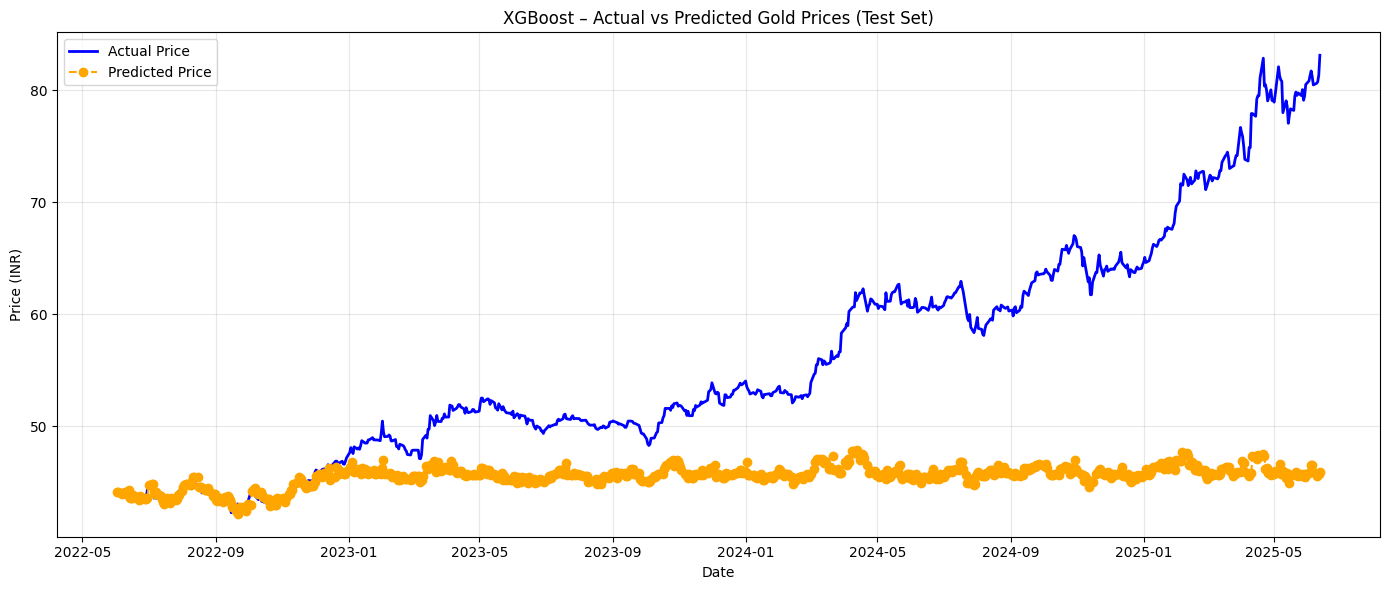

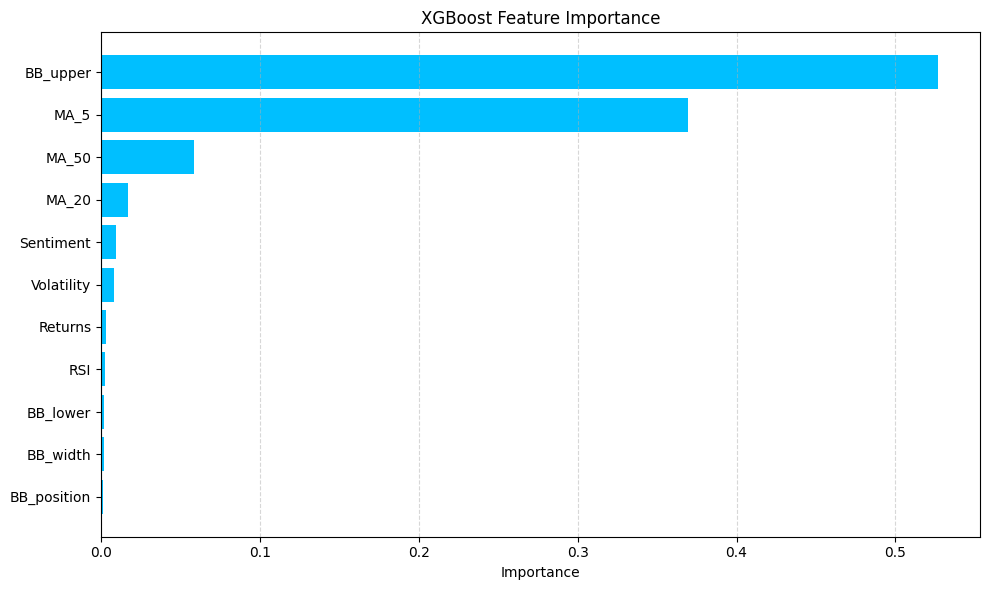

✅ Saved training set to Data/RandomForest_Train/train_data.csv
✅ Saved test set to Data/RandomForest_Train/test_data.csv
📉 Random Forest RMSE on test set: 14.51
📈 Predicted next day's gold price: ₹45.25


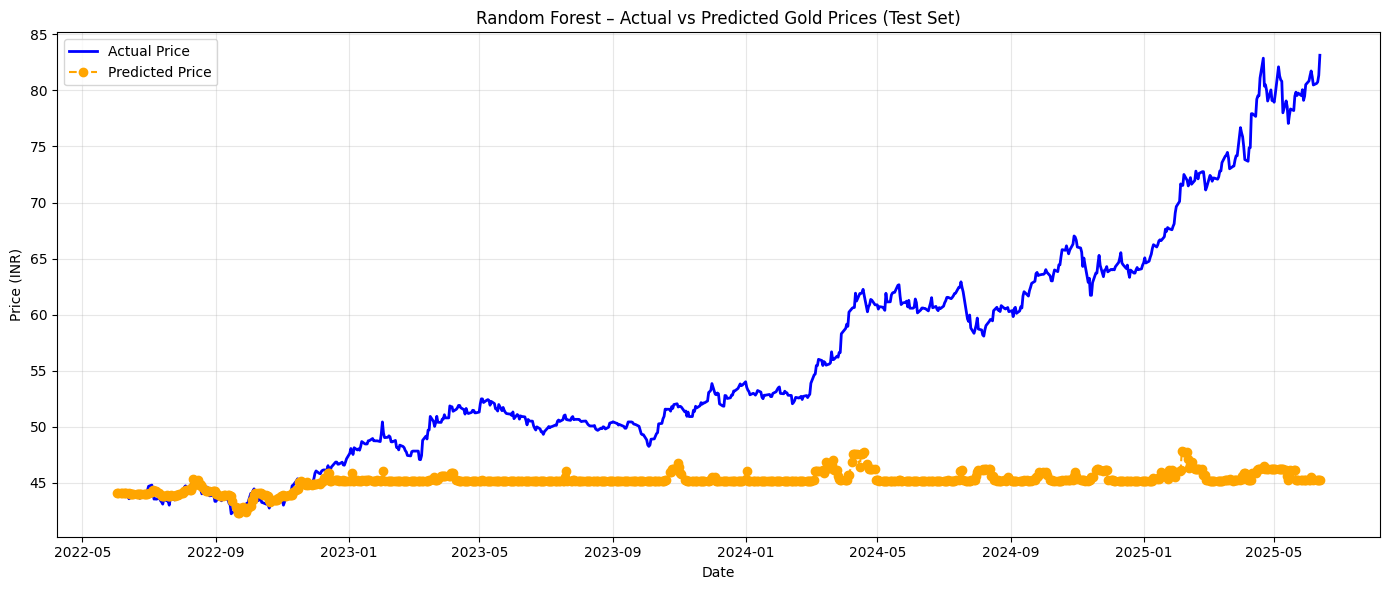

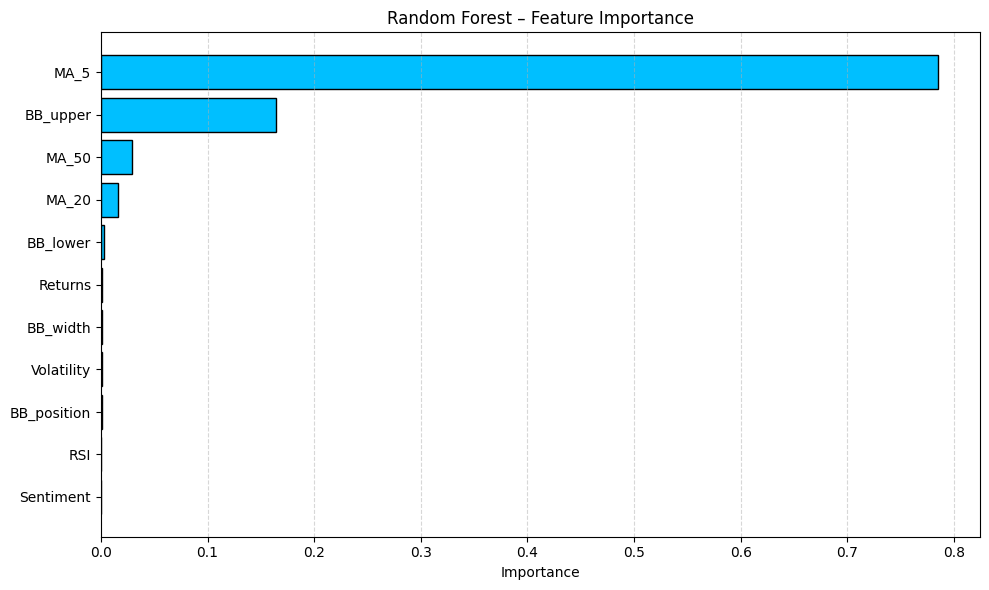

✅ PyTorch running on: GPU (CUDA)
🧠 Training started...
Epoch 0 - Loss: 0.000109
Epoch 10 - Loss: 0.000036
Epoch 20 - Loss: 0.000204
Epoch 30 - Loss: 0.000022
Epoch 40 - Loss: 0.000023
Epoch 49 - Loss: 0.000053
📈 Predicted next day's gold price (LSTM): ₹77.10


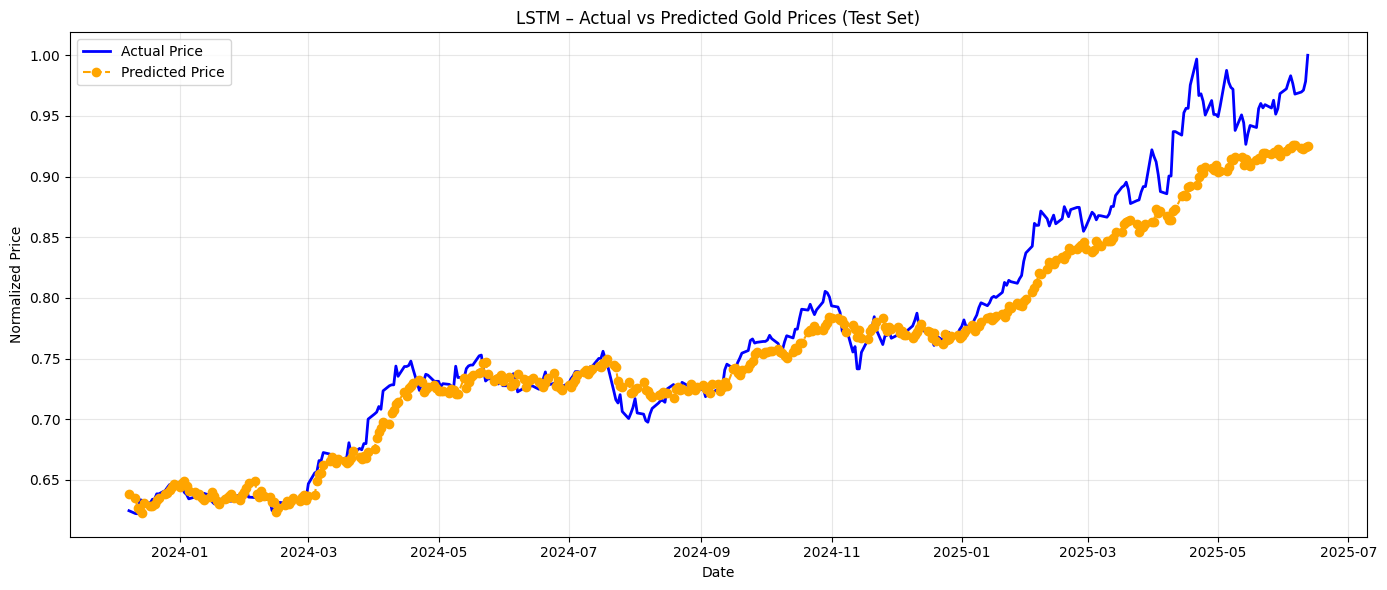

C:\Users\BrintaJaison\AppData\Local\Temp\ipykernel_33624\184189140.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Python\04_Python_DA225o\python_env4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


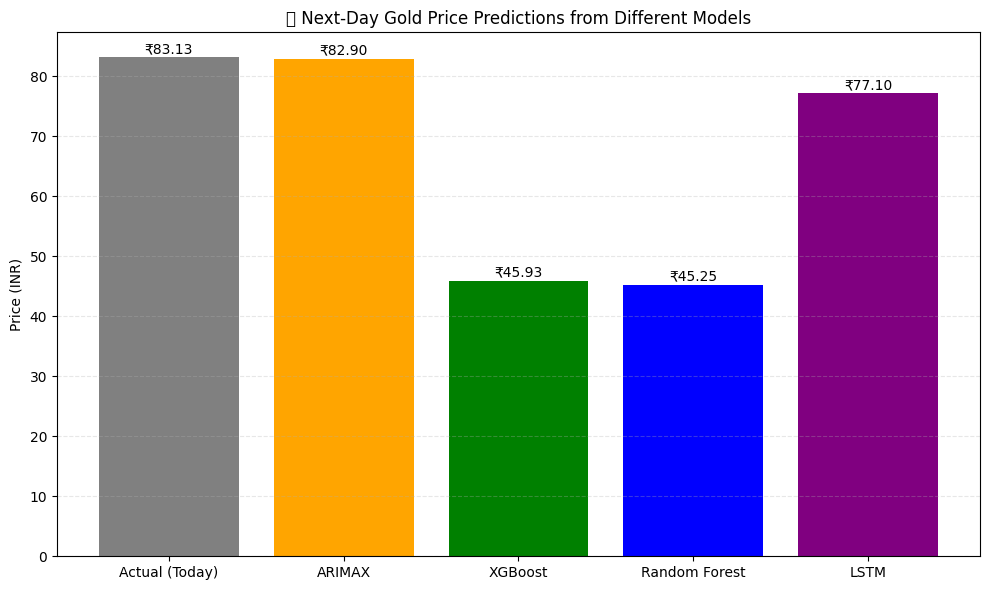

In [131]:
# Main function : Collect and process GOLDBEES (Indian Gold ETF) data with technical indicators
# ---------------------------------------------------------------------    
if __name__ == "__main__":
    start = datetime(2010, 1, 1)
    end = datetime(2026, 1, 1)

    # Step 1: Download and save raw price data
    gold = download_gold_prices(start, end)

        # Step 2: Add and save indicators
    if not gold.empty:
        gold = add_technical_indicators(gold)
        plot_technical_indicators(gold)
        plot_support_resistance(gold, order=10)

    # Step 3: Add sentiment based on price trend
    if not gold.empty:
        # Uncomment one of the following lines to choose the sentiment generation method
        #gold = add_dummy_sentiment(gold)
        #gold = generate_sentiment_from_trend_wo_labels(gold)
        gold = generate_sentiment_from_trend_with_labels(gold)
        plot_sentiment_vs_price(gold)

    # Step 4: Predict next day's gold price using ARIMAX
    if not gold.empty:
        # Predict next day's price using ARIMAX with all indicators
        next_day, predicted_price, model_fit = predict_next_day_gold_price_arimax(gold)
        forecast_df = pd.DataFrame({'Forecast': [predicted_price]}, index=[next_day])
        plot_forecast_vs_actual(gold, forecast_df)
        plot_arimax_feature_weights_h(model_fit, [
            'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
            'RSI', 'BB_upper', 'BB_lower', 'BB_width',
            'BB_position', 'Sentiment'
            ])
        
    # Step 5: Perform rolling ARIMAX forecast for multiple future days
    if not gold.empty:
        forecast_df, final_model_fit = rolling_arimax_forecast(gold, days_ahead=5)
        plot_forecast_vs_actual(gold, forecast_df)
        plot_arimax_feature_weights_h(model_fit, [
            'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
            'RSI', 'BB_upper', 'BB_lower', 'BB_width',
            'BB_position', 'Sentiment'
            ])
    # Step 6: Predict next day's price using XGBoost
    if not gold.empty:
        next_price, xgb_model, X_test, y_test, y_pred = predict_next_day_gold_price_xgboost(gold)
        plot_predictions_vs_actuals(y_test, y_pred, model_name="XGBoost")
        plot_xgboost_feature_importance(xgb_model, [
            'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
            'RSI', 'BB_upper', 'BB_lower', 'BB_width',
            'BB_position', 'Sentiment'
            ])
    # Step 7: Predict next day's price using Random Forest
    if not gold.empty:
        next_price_rf, rf_model, X_test_rf, y_test_rf, y_pred_rf = predict_next_day_gold_price_rf(gold)
        plot_predictions_vs_actuals(y_test_rf, y_pred_rf, model_name="Random Forest")
        plot_rf_feature_importance(rf_model, [
            'Returns', 'MA_5', 'MA_20', 'MA_50', 'Volatility',
            'RSI', 'BB_upper', 'BB_lower', 'BB_width',
            'BB_position', 'Sentiment'
            ])  
    # Step 8: Predict next day's price using LSTM
    if not gold.empty:
        next_price_lstm, lstm_model, y_test_lstm, y_pred_lstm, date_test_lstm = predict_next_day_gold_price_lstm(gold)
        plot_lstm_predictions_vs_actuals(y_test_lstm, y_pred_lstm, dates=date_test_lstm)
    
    # Step 9: Compare all model predictions
    # Ensure we have all predictions before comparing
    if not gold.empty:
        actual_close_price = gold['Close'].dropna().iloc[-1]
        compare_model_predictions(
            actual_price=actual_close_price,
            arimax_price=predicted_price,
            xgb_price=next_price,
            rf_price=next_price_rf,
            lstm_price=next_price_lstm
            )